In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import scipy as sp
from sklearn.mixture import GaussianMixture
import matplotlib.ticker as ticker
from skimage.feature import peak_local_max
from skimage import io, color

%matplotlib inline
rcParams['figure.facecolor'] = 'white'
# plt.rcParams.update({
#     "text.usetex": True
# })

In [2]:
parent_dir = './level4/'
# parent_dir = './lvl5_testruns/'
# original_mw = sorted([directory for directory in os.listdir(parent_dir) if 'Au06' in directory and 'cfea' in directory])
original_mw = sorted([directory for directory in os.listdir(parent_dir) if 'Au' in directory and 'cfea_fiducial' in directory])
# lowmass_mw = sorted([directory for directory in os.listdir(parent_dir) if 'L' in directory and 'cfea_fiducial' in directory])
# dwarfs = sorted([directory for directory in os.listdir(parent_dir) if 'D' in directory and 'cfea_fiducial' in directory])

simulation_list = original_mw# + lowmass_mw + dwarfs
print(simulation_list)

['Au06_cfea_fiducial', 'Au14_cfea_fiducial', 'Au17_cfea_fiducial', 'Au18_cfea_fiducial', 'Au22_cfea_fiducial', 'Au23_cfea_fiducial', 'Au24_cfea_fiducial', 'Au26_cfea_fiducial', 'Au27_cfea_fiducial', 'Au28_cfea_fiducial']


# ICMF sampling test

In [3]:
sim_id = 0
snap_id = 127
print('Loading simulation ', simulation_list[sim_id], ' snapshot ', snap_id)
sf = load_subfind(snap_id, dir=parent_dir+simulation_list[sim_id]+'/output/', hdf5=True, loadonly=['fpos', 'fmm2', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(snap_id, snappath=parent_dir+simulation_list[sim_id]+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0)
s.calc_sf_indizes( sf )
galrad = sf.data['frc2'][0]
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

Loading simulation  Au06_cfea_fiducial  snapshot  127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


array([[-0.05904483,  0.35439216,  0.93323089],
       [ 0.49324374, -0.80241338,  0.3359217 ],
       [ 0.86788497,  0.48014474, -0.12742336]])

In [72]:
solar_mass_g = 1.989e33
Gcosmo = 43.
Gcgs = 6.6743e-8 # gravitational constant in cm^3/g/s^2
k = 1.3807e-16 # boltzmann constant in erg/K (g*cm^2/s^2/K)
parsec = 3.08567758e18 # cm
gyr = 3.15576e16 # seconds

s.parameters['UnitTime_in_s'] = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']

In [73]:
starparts = (s.data['age'] > 0) * (s.r()[s.data['type']==4]<galrad) * (s.data['subhalo'][s.data['type']==4]==0)
mask_cluster_initial = (s.data['incl'][starparts]>0)
mask_cluster_final = (s.data['nclt'][starparts]>0)
imclus = s.data['imcl'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
imtotclus = s.data['imfc'][starparts][mask_cluster_initial]*s.data['mass'][s.data['type']==4][starparts][mask_cluster_initial]*s.UnitMass_in_g/solar_mass_g
inclus = s.data['incl'][starparts][mask_cluster_initial].flatten()
mtrunc = s.data['mtrc'][starparts][mask_cluster_initial] * s.UnitMass_in_g/solar_mass_g

In [74]:
mask_problematic = s.data['imfc']>1.
print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][s.data['incl']>0]) * 100))

Problematic stars with clusters  359
That`s 1.457 per cent of stars with clusters


In [75]:
stars_age = s.cosmology_get_lookback_time_from_a(s.data['age'][starparts], is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

In [76]:
def ICMF(norm, m, mtrunc):
    icmf = norm*np.exp(-m/mtrunc)/m**2
    if type(m) == np.ndarray:
        mask = m < 1e3
        if type(norm) == np.ndarray:
            icmf[mask] = norm[mask] * np.exp(-1e3/mtrunc)/(1e3**2)
        else:
            icmf[mask] = norm * np.exp(-1e3/mtrunc)/(1e3**2)
    else:
        if m < 1e3:
            icmf = norm * np.exp(-1e3/mtrunc)/(1e3**2)
    return icmf

def mICMF(norm, m, mtrunc):
    micmf = norm*np.exp(-m/mtrunc)/m
    if type(m) == np.ndarray:
        mask = m < 1e3
        if type(norm) == np.ndarray:
            micmf[mask] = norm[mask]*np.exp(-1e3/mtrunc)/1e3
        else:
            micmf[mask] = norm*np.exp(-1e3/mtrunc)/1e3
    else:
        if m < 1e3:
            micmf = norm*np.exp(-1e3/mtrunc)/1e3
    return micmf

def trapz_log(norm, min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(norm, current, mtrunc) + IMF(norm, next, mtrunc))
    return integral

In [77]:
nbins = 25
min_gcmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(np.log10(marray_gcmf))

N,_ = np.histogram(imclus[imclus>0], bins=marray_gcmf, density=True)
initial_population = N/width

In [78]:
norm = 1/trapz_log(1., min_gcmf, max_gcmf, mtrunc, ICMF, 500)
norm_real = 1/trapz_log(1., 1e2, max_gcmf, mtrunc, ICMF, 500)

In [79]:
mean_mclus = trapz_log(norm_real, 1e2, max_gcmf, mtrunc, mICMF, 500)
nexp_clus = (s.data['lcfe'][starparts][mask_cluster_initial]*s.data['gima'][starparts][mask_cluster_initial]*1e10)/mean_mclus

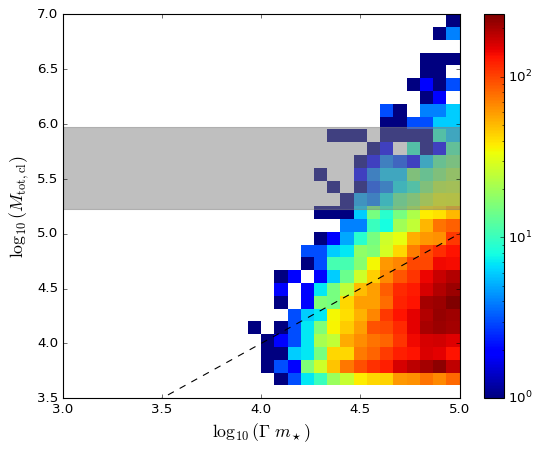

In [80]:
cb = plt.hist2d(np.log10(s.data['lcfe'][starparts][mask_cluster_initial]*s.data['gima'][starparts][mask_cluster_initial]*1e10),
           np.log10(s.data['imfc'][starparts][mask_cluster_initial]*s.data['gima'][starparts][mask_cluster_initial]*1e10), range=([3,5], [3.5,7]), bins=(30,30),rasterized=True, norm=mcolors.LogNorm())
plt.plot(np.linspace(3,7, 50), np.linspace(3,7, 50), 'k--')
plt.fill_betweenx([np.unique(np.log10(1e10*s.data['gima'][starparts][mask_cluster_initial]))[0],np.unique(np.log10(1e10*s.data['gima'][starparts][mask_cluster_initial]))[-1]],\
                   3, 5, where=[True,True], color='grey', alpha=0.5)
plt.xlim(3,5)
plt.ylim(3.5,7)
plt.xlabel(r'$\log_{10} ( \Gamma \; m_\star)$', fontsize=16)
plt.ylabel(r'$\log_{10} ( M_{\rm{tot,cl}})$', fontsize=16)
plt.colorbar(cb[3])

In [81]:
ICMF_array=[]

for i in range(len(mtrunc)):
    ICMF_array.append(ICMF(norm[i], marray_gcmf, mtrunc[i]))

ICMF_array = np.array(ICMF_array)

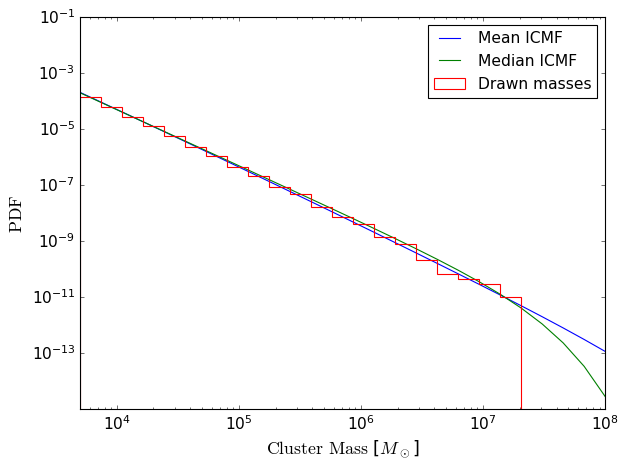

In [82]:
plt.loglog(marray_gcmf, np.nanmean(ICMF_array,axis=0), label='Mean ICMF')
plt.loglog(marray_gcmf, np.nanmedian(ICMF_array,axis=0), label='Median ICMF')
# plt.hist(imtotclus/inclus, bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
plt.hist(imclus[imclus>0], bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
# plt.step(marray_gcmf[:-1], initial_population, where='post', label='Initial Population')
plt.legend(fontsize=14)
# plt.ylim(1e-13, 1e-1)
plt.xlim(min_gcmf, max_gcmf)
plt.xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.yticks(np.logspace(-13, -1, 7))
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tight_layout()
# plt.savefig('plots/icmf_sampling_test_consistent.pdf')

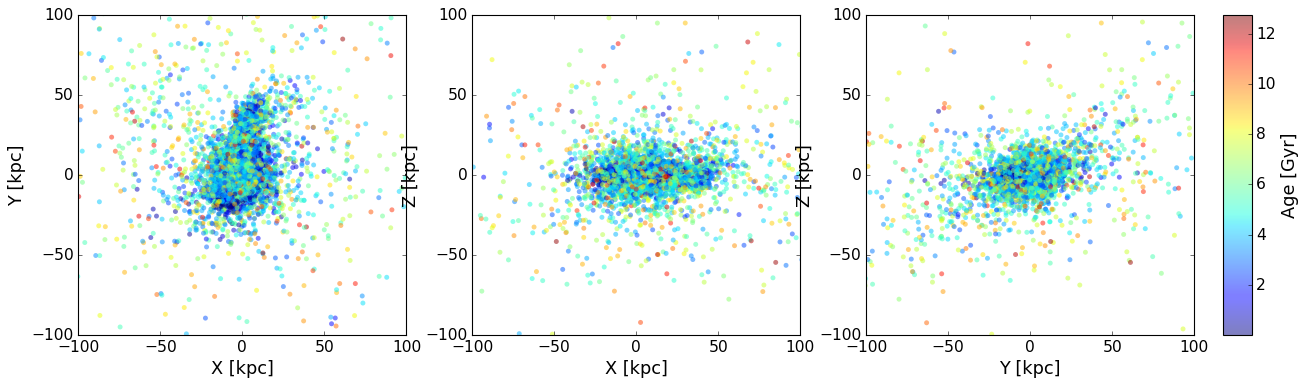

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[0].set_xlim(-100,100)
ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[2].set_xlim(-100,100)
ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

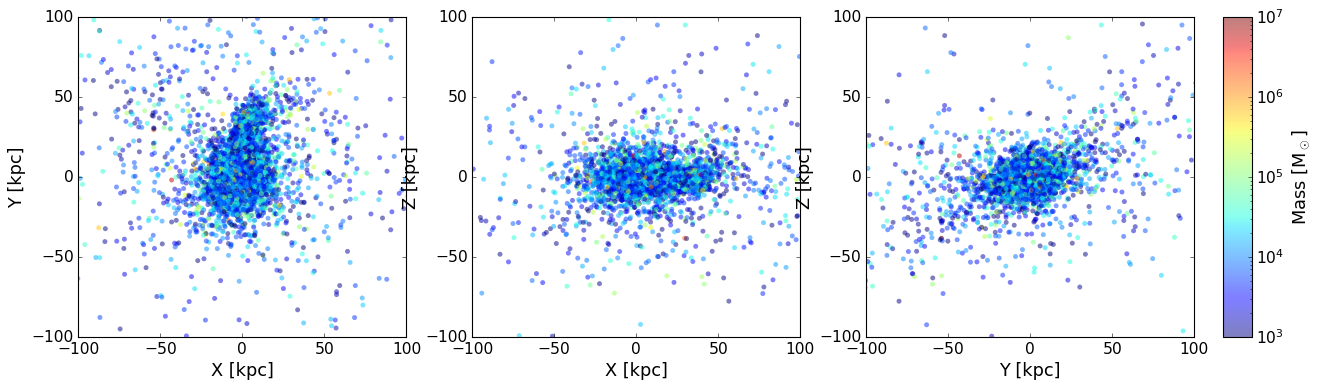

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2], 
              c=(1e10*s.data['mass'][s.data['type']==4][starparts]*s.data['mfcl'][starparts])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[0].set_xlim(-100,100)
ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0], 
              c=(1e10*s.data['mass'][s.data['type']==4][starparts]*s.data['mfcl'][starparts])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0], 
              c=(1e10*s.data['mass'][s.data['type']==4][starparts]*s.data['mfcl'][starparts])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[2].set_xlim(-100,100)
ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Mass [M$_\odot$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_mass_distribution.pdf')

In [85]:
mclus = s.data['mclt'][starparts][mask_cluster_final].flatten()
mclus = mclus[mclus>0]
nclus = s.data['nclt'][starparts][mask_cluster_final]

In [86]:
kinetic_energy = np.sum(s.data['vel']**2, axis=1)

orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
orbital_energy /= 1e5

J_mod = np.sqrt((np.cross(s.data['pos'], s.data['vel'])**2).sum(axis=1))
Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]

parts_radius = s.r()
isort_parts = np.argsort(parts_radius)
revert_sort = np.argsort(isort_parts)
cummass = np.cumsum(s.data['mass'][isort_parts])
Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
Ecirc /= 1e5
e_max = np.nanmax(Ecirc[~np.isinf(Ecirc)])
orbital_energy -= e_max
Ecirc -= e_max

In [87]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

# Example usage
mask = mask_equal_to_previous(parts_radius[isort_parts][~np.isinf(Ecirc)])

In [88]:
r_test = np.logspace(-5, np.log10(parts_radius.max()), 500)
Ecirc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask])
Vc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask])
Mr_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask])

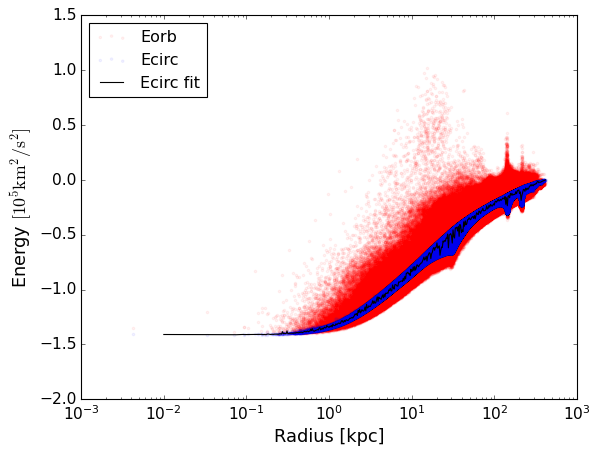

In [89]:
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], orbital_energy[isort_parts][~np.isinf(Ecirc)][mask], c='r', edgecolors='face', label='Eorb', s=5, alpha=0.05)
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask], edgecolors='face', label='Ecirc', s=5, alpha=0.05)
plt.plot(1e3*r_test, Ecirc_f(r_test), c='k', label='Ecirc fit')
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Energy $[10^5 \rm{km}^2/\rm{s}^2]$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

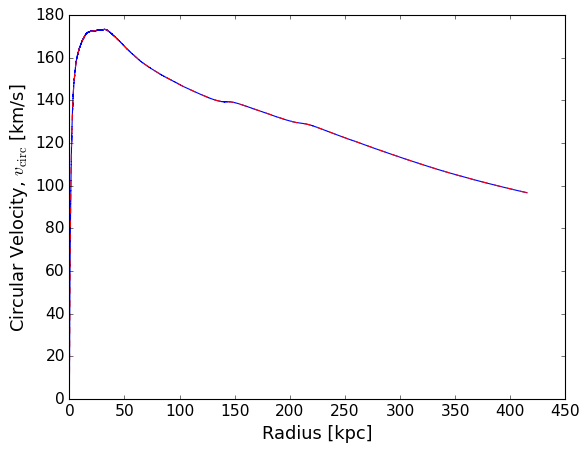

In [90]:
plt.plot(1e3*parts_radius[isort_parts], Vc_parts[isort_parts])
plt.plot(1e3*r_test, Vc_f(r_test), 'r--')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Circular Velocity, $v_{\rm{circ}}$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14)

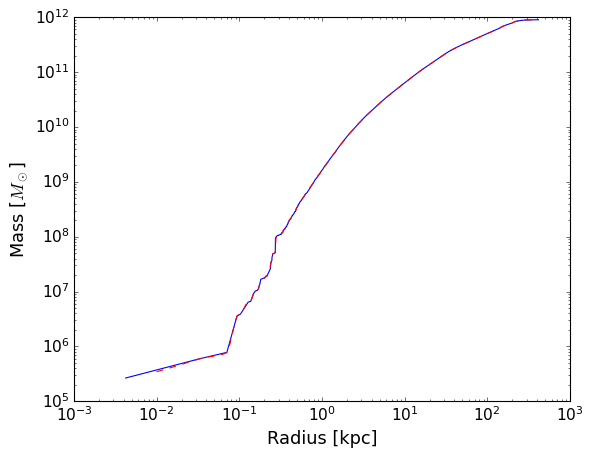

In [91]:
plt.plot(1e3*parts_radius[isort_parts], 1e10*cummass)
plt.plot(1e3*r_test, 1e10*Mr_f(r_test), 'r--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Mass [$M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [92]:
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    if velocities.size == 0:
        return 0.0
    # Avoid division by zero
    else:
        return np.std(velocities)

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

In [93]:
idx = np.argmin(np.abs(orbital_energy[s.data['type']==4][starparts][mask_cluster_final][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
rc_clus = r_test[idx]
vc_rc_clus = Vc_f(rc_clus)
M_rc_clus = Mr_f(rc_clus)
# sigma_rc_clus = np.array([velocity_dispersion(rc, parts_radius, starparts, s.data['age'], s.data['vel'], s.data['type']) for rc in rc_clus])

rc_clus = np.repeat(rc_clus, nclus)
M_rc_clus = np.repeat(M_rc_clus, nclus)
vc_rc_clus = np.repeat(vc_rc_clus, nclus)
# sigma_rc_clus = np.repeat(sigma_rc_clus, nclus)

In [94]:
r_clus = np.repeat(parts_radius[s.data['type']==4][starparts][mask_cluster_final],nclus)
vc_clus = np.repeat(Vc_parts[s.data['type']==4][starparts][mask_cluster_final],nclus)

(0.0, 500.0)

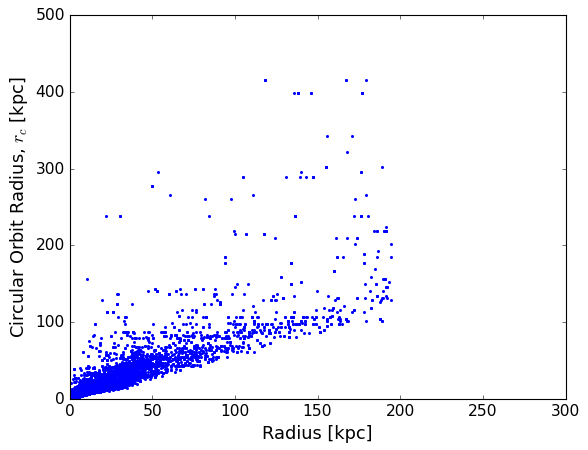

In [95]:
plt.scatter(1e3*r_clus,1e3*rc_clus, s=3, edgecolors='face')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.xlim(0,300)
plt.ylim(0,500)

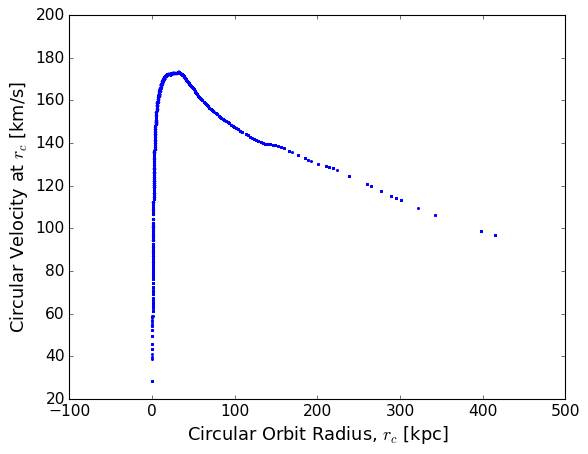

In [96]:
plt.scatter(1e3*rc_clus,vc_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel('Circular Velocity at $r_c$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

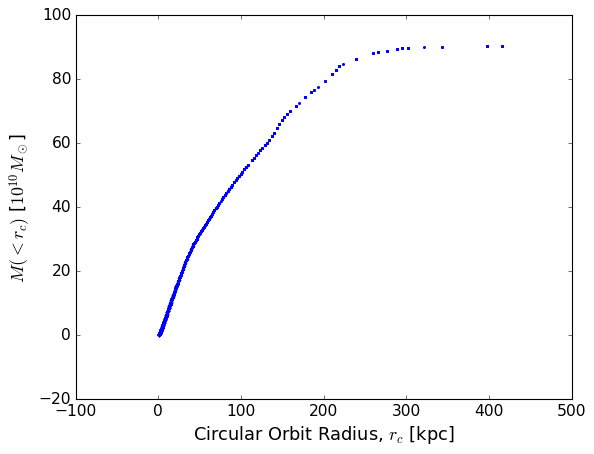

In [97]:
plt.scatter(1e3*rc_clus,M_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel(r'$M(<r_c)$ [$10^{10} M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [98]:
# plt.scatter(1e3*rc_clus,sigma_rc_clus, s=3, edgecolors='face')
# plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
# plt.ylabel('Velocity Dispersion [km/s]', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [99]:
Jc_clus = rc_clus*vc_clus
# circ_param_clus0 = np.repeat(Lz[starparts][mask_cluster_final],s.data['nclt'][mask_cluster_final])/Jc_clus
circ_param_clus1 = (np.repeat(J_mod[s.data['type']==4][starparts][mask_cluster_final],s.data['nclt'][starparts][mask_cluster_final])/Jc_clus)

In [100]:
circ_param_clus1.min(), circ_param_clus1.max()

(np.float64(0.008769373607083148), np.float64(1.7046262881017198))

In [101]:
feps = (circ_param_clus1)**0.78
coulumblog = np.log(1. + M_rc_clus/mclus)

In [102]:
# tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*mclus*coulumblog)
# tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)
# np.nanmin(tdf), np.nanmax(tdf)
clus_age = np.repeat(stars_age[mask_cluster_final],nclus)
clus_age_i = np.repeat(stars_age[mask_cluster_initial],s.data['incl'][starparts][mask_cluster_initial])
# mask_disrupted = (tdf<clus_age)
# mask_disrupted.sum()

In [103]:
# plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
# plt.xscale('log')
# plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
# plt.ylabel('Number of Clusters', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [104]:
# cb = plt.scatter(tdf, 1e10*mclus, s=3, c=clus_age, edgecolors='face')
# plt.xscale('log')
# plt.yscale('log')
# cbar = plt.colorbar(cb)
# cbar.set_label('Age [Gyr]', fontsize=16)
# cbar.ax.tick_params(labelsize=14)
# plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
# plt.ylabel('Cluster Mass [$M_\odot$]', fontsize=16)
# xticks = plt.xticks()[0]
# plt.xticks(xticks[::2])
# plt.tick_params(axis='both', which='both', labelsize=14)

In [105]:
nbins = 20
min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)

In [106]:
# plt.hist(np.log10(1e10*mclus[mask_disrupted]), bins=marray_gcmf, histtype='step', label='All Clusters', linewidth=3)
# plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
# plt.ylabel(r'$\rm{Disrupted \; Clusters} (\tau < t_{\rm{DF}})$', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [107]:
Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)
jz = Lz[s.data['type']==4][starparts]
ii = np.argsort(orbital_energy[s.data['type']==4][starparts])
eps = jz[ii]
npm = 50
eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
ilist = ilist[ii] # ilist=5,4,3,2,1
resort = np.argsort(ilist) # resort=5,4,3,2,1
eps = eps[resort] # eps2=5,4,3,2,1

# Build feature array: [ε, Energy]
X = np.vstack((eps,orbital_energy[s.data['type']==4][starparts],
               np.log10(np.abs(s.data['pos'][:,0][s.data['type']==4][starparts])))).T

# Fit GMM
gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[s.data['type']==4][starparts]), -2.0],
                                                  [0.9,np.median(orbital_energy[s.data['type']==4][starparts]), -5.0]],
                                                   covariance_type='full', random_state=42)
gmm.fit(X)

# Predict cluster memberships
decomp_labels = gmm.predict(X)

In [108]:
median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
sph_label = np.argmin(median_eps)
disc_label = np.argmax(median_eps)

# Force assign disc_label to clusters with high circularity parameter
mask = (decomp_labels == sph_label) & (eps > 0.7)# & (s.r()[starparts] < np.percentile(s.r()[starparts][decomp_labels == disc_label], 0.5))
decomp_labels[mask] = disc_label

# Force assign sph_label to clusters with high z-coordinate (5kpc)
mask = (decomp_labels == disc_label) & (np.abs(s.data['pos'][:,0][s.data['type']==4][starparts])*1e3 > 5.)
decomp_labels[mask] = sph_label

print('GMM Label for Spheroid:', sph_label)
print('GMM Label for Disc:', disc_label)

GMM Label for Spheroid: 1
GMM Label for Disc: 0


In [109]:
#Force assign disc_label to clusters with high circularity
mask = (decomp_labels == sph_label) & (eps > 0.7) & (s.r()[s.data['type']==4][starparts] < np.percentile(s.r()[s.data['type']==4][starparts][decomp_labels == disc_label], 0.75))
decomp_labels[mask] = disc_label

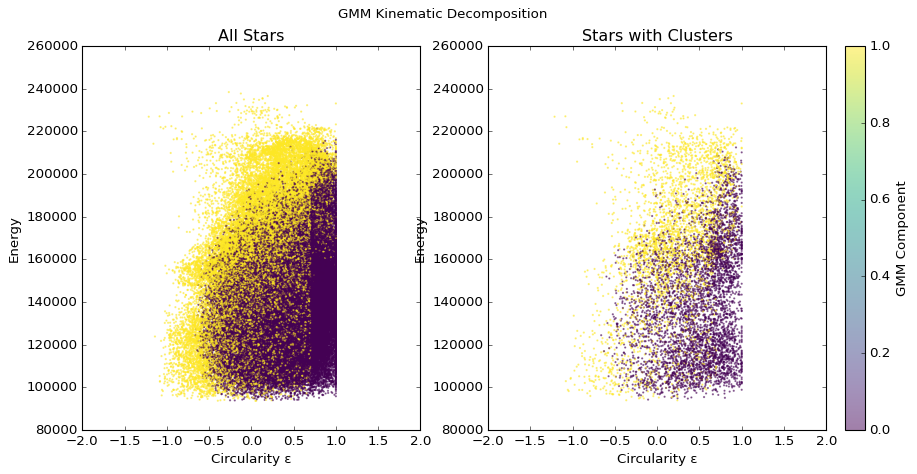

In [110]:
# mask = (s.data['nclt'][(s.data['age']>0)*(parts_radius[starparts]<galrad)]>0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(eps, orbital_energy[s.data['type']==4][starparts], c=decomp_labels, s=1, cmap='viridis', alpha=0.5, edgecolors='face')
cb = ax[1].scatter(eps[mask_cluster_final], orbital_energy[s.data['type']==4][starparts][mask_cluster_final], c=decomp_labels[mask_cluster_final], s=1, cmap='viridis', alpha=0.5, edgecolors='face')
for i in range(2):
    ax[i].set_xlabel('Circularity ε')
    ax[i].set_xlim(-2,2)
    ax[i].set_ylabel('Energy')
fig.suptitle('GMM Kinematic Decomposition')
ax[0].set_title('All Stars')
ax[1].set_title('Stars with Clusters')
fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]), label='GMM Component')

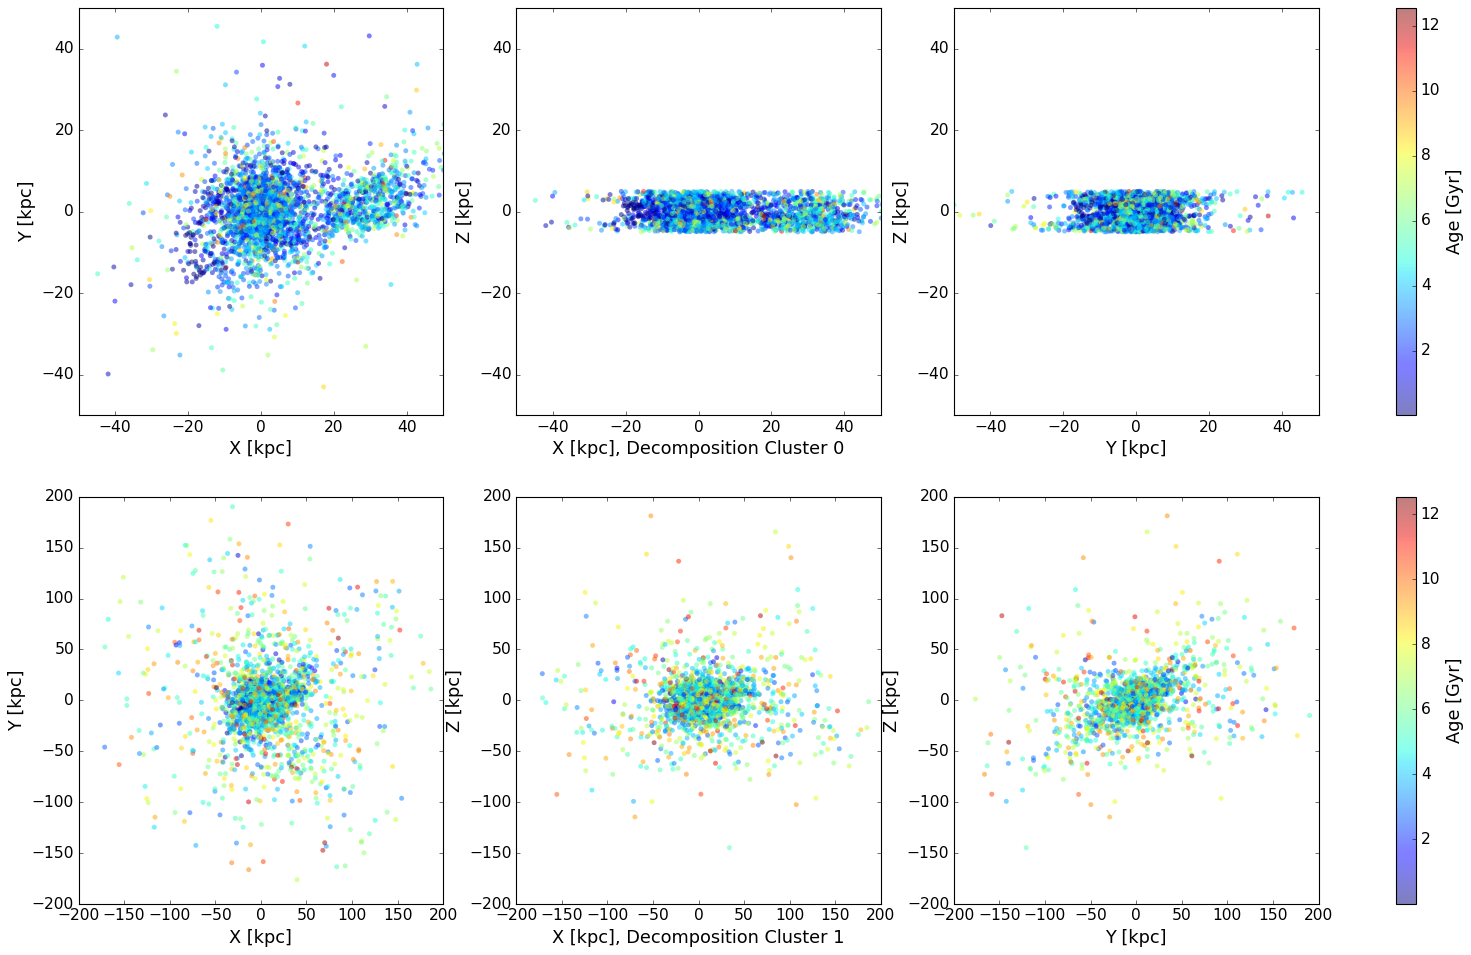

In [111]:
# nlabels = gmm.n_components
nlabels = 2
fig, ax = plt.subplots(nlabels, 3, figsize=(25,7*nlabels))
cbars = []
for i in range(nlabels):
    ax[i,0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,1],
                    c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==i], alpha=0.5, linewidth=0)
    ax[i,0].set_xlabel('X [kpc]', fontsize=16)
    ax[i,0].set_ylabel('Y [kpc]', fontsize=16)
    ax[i,0].tick_params(axis='both', which='both', labelsize=14)
    ax[i,1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,0],
                    c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==i], alpha=0.5, linewidth=0)
    ax[i,1].set_xlabel('X [kpc], Decomposition Cluster {:1d}'.format(i), fontsize=16)
    ax[i,1].set_ylabel('Z [kpc]', fontsize=16)
    ax[i,1].tick_params(axis='both', which='both', labelsize=14)
    cb = ax[i, 2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,0],
                    c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==i], alpha=0.5, linewidth=0)
    cbars.append(cb)
    ax[i, 2].set_xlabel('Y [kpc]', fontsize=16)
    ax[i, 2].set_ylabel('Z [kpc]', fontsize=16)
    ax[i, 2].tick_params(axis='both', which='both', labelsize=14)
    if i==sph_label:
        for j in range(3):
            ax[i,j].set(xlim=(-200,200), ylim=(-200,200))
    else:
        for j in range(3):
            ax[i,j].set(xlim=(-50,50), ylim=(-50,50))
# plt.tight_layout()
for i, cbar in enumerate(cbars):
    cbar = fig.colorbar(cb, ax=ax[i].ravel().tolist())
# cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
# cbar = fig.colorbar(cb, ax=ax.ravel().tolist())
    cbar.set_label('Age [Gyr]', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

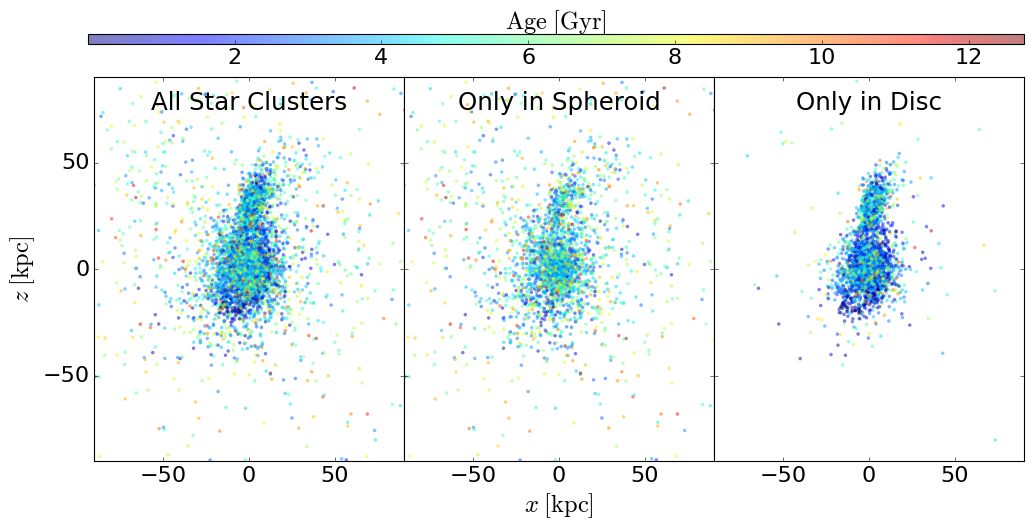

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.})

cb = ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2],
              c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0, s=10, rasterized=True)
ax[0].set_xlim(-90, 90)
ax[0].set_ylim(-90, 90)
ax[0].text(0, 75, 'All Star Clusters', ha='center', fontsize=22)

ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label][:,2],
              c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label], alpha=0.5, linewidth=0, s=10, rasterized=True)
ax[1].set_xlim(-90, 90)
ax[1].text(0, 75, 'Only in Spheroid', ha='center', fontsize=22)

ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label][:,2],
              c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label], alpha=0.5, linewidth=0, s=10, rasterized=True)
ax[2].set_xlim(-90, 90)
ax[2].text(0, 75, 'Only in Disc', ha='center', fontsize=22)

ax[0].set_ylabel(r'$z \; \rm{[kpc]}$', fontsize=22)
ax[1].set_xlabel(r'$x \; \rm{[kpc]}$', fontsize=22)
ax[0].tick_params(axis='both', which='both', labelsize=20)
ax[1].tick_params(axis='both', which='both', labelsize=20)
ax[2].tick_params(axis='both', which='both', labelsize=20)

cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.97, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$\rm{Age} \; [\rm{Gyr}]$', fontsize=22)
cbar.ax.tick_params(labelsize=20)

# plt.savefig('./plots/position_age_distribution_decomp_paper.pdf', bbox_inches='tight')

In [113]:
mask_old_sph = stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label] > 6.0
mask_old_disc = stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label] > 6.0

print('Fraction of young clusters in spheroid: {:.3f}'.format((~mask_old_sph).sum()/len(stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label])))
print('Fraction of old clusters in disc: {:.3f}'.format(mask_old_disc.sum()/len(stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label])))

Fraction of young clusters in spheroid: 0.729
Fraction of old clusters in disc: 0.124


([], [])

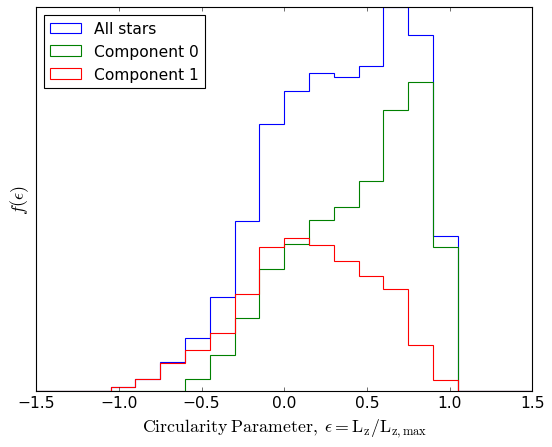

In [114]:
plt.hist(eps, histtype='step', bins=20, range=[-1.5,1.5], label='All stars')
for i in range(2):
    plt.hist(eps[decomp_labels==i], histtype='step', bins=20, range=[-1.5,1.5], label=f'Component {i}')
plt.legend(loc='upper left', fontsize=14)
# plt.vlines(0.8,0,1.4, color='r', linestyles='dashed')
plt.xlabel(r'$\rm{Circularity \; Parameter}, \; \epsilon = L_z/L_{z,\mathrm{max}}$', fontsize=16)
plt.ylabel(r'$f(\epsilon)$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.yticks([])

In [115]:
labels = np.repeat(decomp_labels[mask_cluster_final], s.data['nclt'][starparts][mask_cluster_final])
labels_i = np.repeat(decomp_labels[mask_cluster_initial], s.data['incl'][starparts][mask_cluster_initial])

Text(0, 0.5, '$\\mathrm{d}N \\, / \\, \\mathrm{d} \\log M_{\\mathrm{cl}}$')

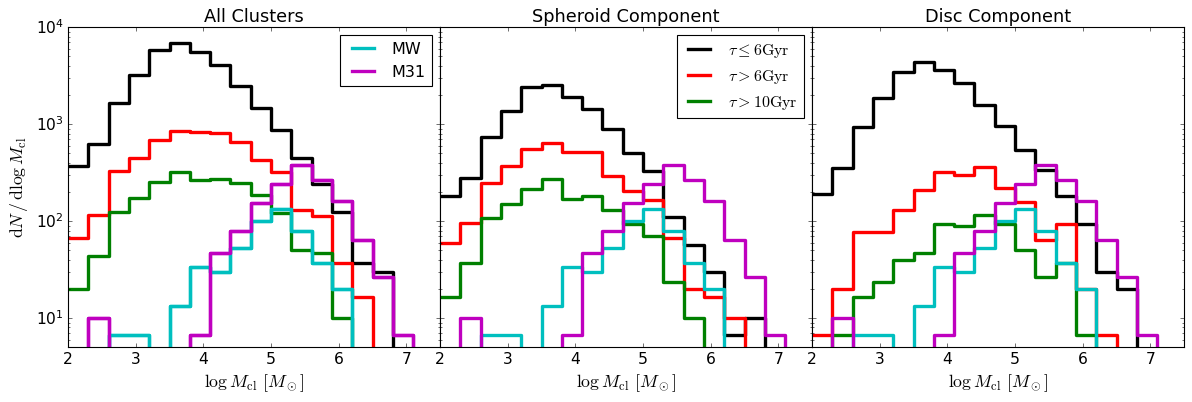

In [116]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width

fig, ax = plt.subplots(1,3, figsize=(18,5), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.})

N,_ = np.histogram(np.log10(1e10*mclus[(clus_age<=6.)]), bins=marray_gcmf)
all_clusters = N/width
# N,_ = np.histogram(np.log10(1e10*mclus), bins=marray_gcmf)
# after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>8.)]), bins=marray_gcmf)
after_df_old = N/width

ax[0].step(marray_gcmf[:-1], all_clusters, where='post',c='k', linewidth = 3)
# ax[0].step(marray_gcmf[:-1], after_df, where='post',c='b', linewidth = 3)
ax[0].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3)
ax[0].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3)
ax[0].step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='c', label='MW')
ax[0].step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='m', label='M31')
ax[0].set_title('All Clusters', fontsize=16)

N,_ = np.histogram(np.log10(1e10*mclus[(labels==sph_label) * (clus_age<=6.)]), bins=marray_gcmf)
after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.) * (labels==sph_label)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>8.) * (labels==sph_label)]), bins=marray_gcmf)
after_df_old = N/width

ax[1].step(marray_gcmf[:-1], after_df, where='post',c='k', linewidth = 3, label=r'$\tau \leq 6 \rm{Gyr}$')
ax[1].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3, label=r'$\tau > 6 \rm{Gyr}$')
ax[1].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3, label=r'$\tau > 10 \rm{Gyr}$')
ax[1].set_title('Spheroid Component', fontsize=16)

N,_ = np.histogram(np.log10(1e10*mclus[(labels==disc_label) * (clus_age<=6.)]), bins=marray_gcmf)
after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.) * (labels==disc_label)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>8.) * (labels==disc_label)]), bins=marray_gcmf)
after_df_old = N/width

ax[2].step(marray_gcmf[:-1], after_df, where='post',c='k', linewidth = 3)
ax[2].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3)
ax[2].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3)
ax[2].set_title('Disc Component', fontsize=16)

for ax_i in ax:
    ax_i.step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='c')
    ax_i.step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='m')
    ax_i.set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
    ax_i.set_xlim(2, 7.5)
    ax_i.tick_params(axis='both', which='both', labelsize=14)
ax[0].legend()
ax[1].legend()
ax[0].set_yscale('log')
ax[0].set_ylim(5e0, 1e4)
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)

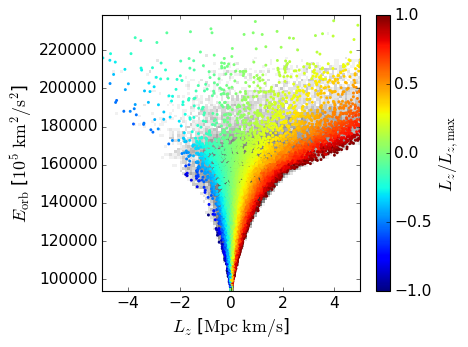

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
#index, = np.where((s.r() < 0.1) & (s.r() > 0.0))
ax.hist2d( Lz[s.data['type']==4][starparts], orbital_energy[s.data['type']==4][starparts], bins=(100, 100), range=([-5, 5], [orbital_energy[s.data['type']==4][starparts].min(), orbital_energy[s.data['type']==4][starparts].max()]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter(Lz[s.data['type']==4][starparts][mask_cluster_final], orbital_energy[s.data['type']==4][starparts][mask_cluster_final], c=eps[mask_cluster_final], vmin=-1, vmax=1, s=7, edgecolors='face', linewidth=0)
# ax.set_ylim(orbital_energy[s.data['type']==4][starparts].min(), 0)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label(r'$L_z / L_{z,\rm{max}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

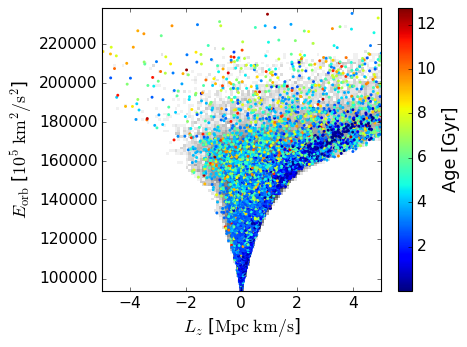

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.hist2d( Lz[s.data['type']==4][starparts], orbital_energy[s.data['type']==4][starparts], bins=(100, 100), range=([-5, 5], [orbital_energy[s.data['type']==4][starparts].min(), orbital_energy[s.data['type']==4][starparts].max()]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter( Lz[s.data['type']==4][starparts][mask_cluster_final], orbital_energy[s.data['type']==4][starparts][mask_cluster_final], c=stars_age[mask_cluster_final], s=7, edgecolors='face', linewidth=0)
# ax.set_ylim(orbital_energy[s.data['type']==4][starparts].min(), 0)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [119]:
# plt.hist(clus_age[~mask_disrupted], bins=20, histtype='step', density=True, label='All Clusters')
# plt.hist(clus_age[(~mask_disrupted) * (labels == 0)], bins=20, histtype='step', density=True, label=r'GCs candidates (Spheroidal)')
# plt.ylim(0, 0.35)
# plt.legend(loc='upper left', fontsize=14)
# plt.xlabel('Cluster`s age [Gyr]', fontsize=16)
# plt.ylabel('Age Distribution', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [120]:
s.data['bprs'] *= s.hubbleparam**2 / s.data['age']**3
s.data['bsig'] *= s.hubbleparam**2 / s.data['age']**3

In [121]:
pressure_units = s.parameters['UnitMass_in_g'] / s.parameters['UnitLength_in_cm'] / (s.parameters['UnitTime_in_s']**2)
density_units = s.parameters['UnitMass_in_g'] / (s.parameters['UnitLength_in_cm']**3)
surface_dens_units = s.parameters['UnitMass_in_g'] / (s.parameters['UnitLength_in_cm']**2)

Text(0, 0.5, '$\\log P/k$ [$\\rm{K}/\\rm{cm}^3$]')

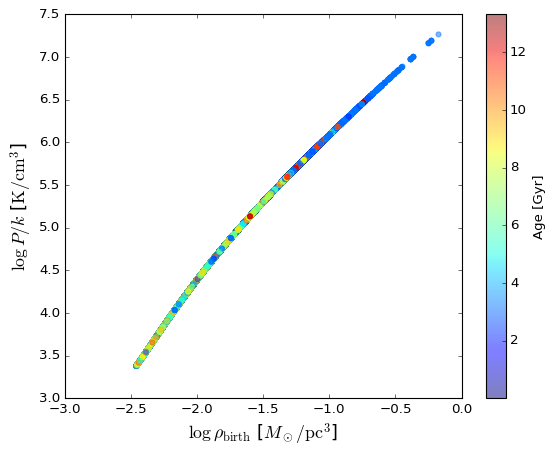

In [122]:
logPoverk = np.repeat(np.log10(s.data['bprs'][starparts][mask_cluster_initial]*pressure_units/k), s.data['nclt'][starparts][mask_cluster_initial])
logPoverk_i = np.repeat(np.log10(s.data['bprs'][starparts][mask_cluster_initial]*pressure_units/k), s.data['incl'][starparts][mask_cluster_initial])
logdens = np.repeat(np.log10(s.data['bdens'][starparts][mask_cluster_initial]*density_units * parsec**3/solar_mass_g), s.data['nclt'][starparts][mask_cluster_initial])
logdens_i = np.repeat(np.log10(s.data['bdens'][starparts][mask_cluster_initial]*density_units * parsec**3/solar_mass_g), s.data['incl'][starparts][mask_cluster_initial])

plt.scatter(logdens_i, logPoverk_i, c=clus_age_i, alpha=0.5, edgecolors='face')
plt.colorbar(label='Age [Gyr]')
plt.xlabel(r'$\log \rho_{\rm{birth}}$ [$M_\odot/\rm{pc}^3$]', fontsize=16)
plt.ylabel(r'$\log P/k$ [$\rm{K}/\rm{cm}^3$]', fontsize=16)

Text(0, 0.5, '$\\log P_{\\rm{cold}}/k$ [$\\rm{K}/\\rm{cm}^3$]')

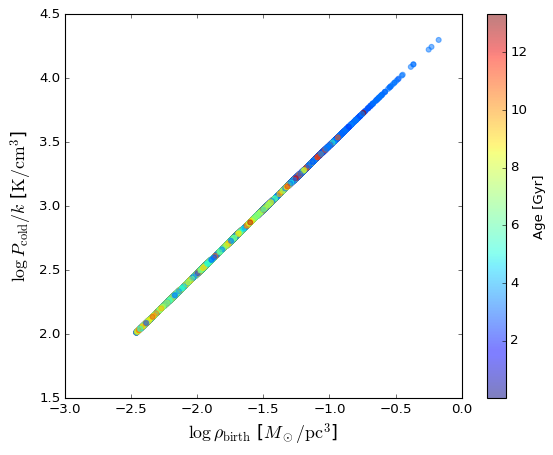

In [123]:
gammaminus1 = 5./3. - 1.
Tcold = 1000
mp = 1.67262178e-24
meanweight = 4./(1. + 3.*0.76)
egyspeccold = 1/meanweight * 1/gammaminus1 * k * Tcold / mp
Pcold = gammaminus1 * 0.9 * s.data['bdens'][starparts][mask_cluster_initial]*density_units * egyspeccold
logPoverk_cold = np.log10(Pcold/k)

plt.scatter(np.log10(s.data['bdens'][starparts][mask_cluster_initial]*density_units * parsec**3/solar_mass_g), logPoverk_cold, c=stars_age[mask_cluster_initial], alpha=0.5, edgecolors='face')
plt.colorbar(label='Age [Gyr]')
plt.xlabel(r'$\log \rho_{\rm{birth}}$ [$M_\odot/\rm{pc}^3$]', fontsize=16)
plt.ylabel(r'$\log P_{\rm{cold}}/k$ [$\rm{K}/\rm{cm}^3$]', fontsize=16)

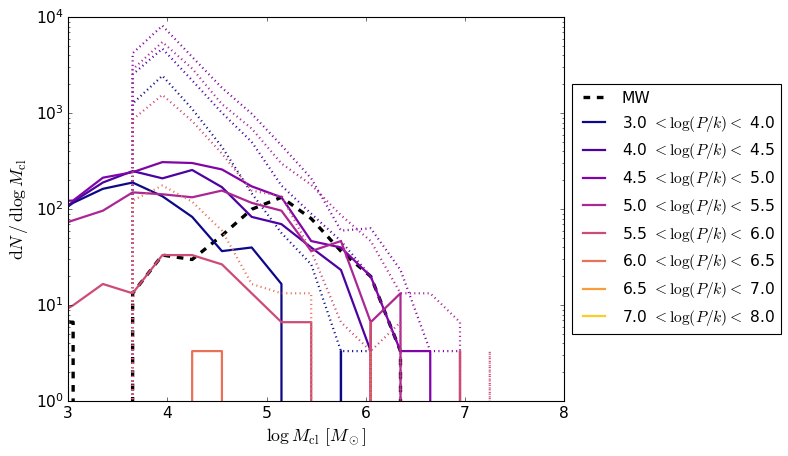

In [124]:
bins_logPoverk = np.concatenate([[3.0],np.arange(4,7.5,0.5),[8.0]])
colors = plt.cm.plasma(np.linspace(0, 0.9, 8))
plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., mw_mass_function, 'k--', linewidth=3, label='MW')
# plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., m31_mass_function, 'k-.', linewidth=3, label='M31')
for i in range(8):
    mask = (logPoverk > bins_logPoverk[i]) & (logPoverk < bins_logPoverk[i+1])
    mask_i = (logPoverk_i > bins_logPoverk[i]) & (logPoverk_i < bins_logPoverk[i+1])
    N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.) * mask]), bins=marray_gcmf)
    after_df_intermediate = N/width
    plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., after_df_intermediate, c=colors[i], linewidth = 2, label=f'{bins_logPoverk[i]:.1f} $< \log(P/k) <$ {bins_logPoverk[i+1]:.1f}')
    N,_ = np.histogram(np.log10(imclus[imclus>0][(clus_age_i>6.) * mask_i]), bins=marray_gcmf)
    initial_per_pressbin = N/width
    plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., initial_per_pressbin, c=colors[i], linestyle = 'dotted', linewidth = 2)

plt.yscale('log')
# plt.ylim(5e0, 5e3)
plt.xlim(3, 8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
# plt.savefig('plots/gcmf_per_birthpressure.pdf',bbox_inches='tight')

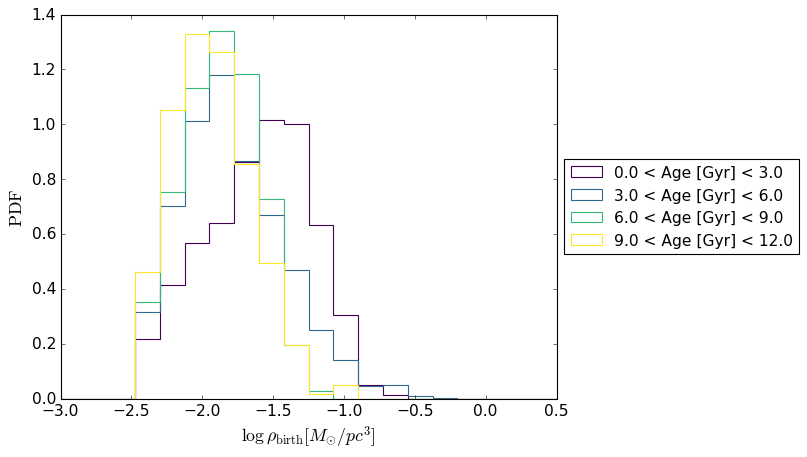

In [125]:
bins_ages = np.arange(0, 15, 3)
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for i in range(len(bins_ages)-1):
    mask = (clus_age > bins_ages[i]) & (clus_age < bins_ages[i+1])
    plt.hist(logdens[mask], bins=20, range=[-3, 0.5], histtype='step', density=True, color=colors[i], label=f'{bins_ages[i]:.1f} < Age [Gyr] < {bins_ages[i+1]:.1f}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log \rho_{\rm{birth}} [M_{\odot}/pc^3]$', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

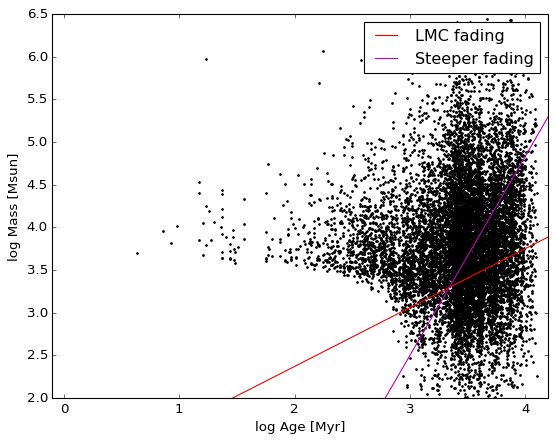

In [126]:
plt.scatter(np.log10(1e3*clus_age), np.log10(1e10*mclus), c='k', s=2)
logage = np.linspace(1, 4.2, 100)
fading1 = 0.69*logage + 0.99
fading2 = 7/3. * logage - 4.5
plt.plot(logage, fading1, c='r', label='LMC fading')
plt.plot(logage, fading2, c='m', label='Steeper fading')
plt.xlim(-.1, 4.2)
plt.ylim(2, 6.5)
plt.xlabel('log Age [Myr]')
plt.ylabel('log Mass [Msun]')
plt.legend()

In [127]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = sp.interpolate.interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

In [128]:
mclus_i = s.data['imcl'][starparts].flatten()
mclus_m = s.data['mclt'][starparts].flatten()
mlsh = s.data['mlsk'][starparts].flatten()
mlrx = s.data['mlrx'][starparts].flatten()
drpt_t = s.data['drpt'][starparts].flatten()
rh_i = s.data['ircl'][starparts].flatten()
rh_m = s.data['rclt'][starparts].flatten()
drpt_t = drpt_t[mclus_i>0]
mclus_m = mclus_m[mclus_i>0]*1e10
mlsh = mlsh[mclus_i>0]*1e10
mlrx = mlrx[mclus_i>0]*1e10
rh_i = rh_i[mclus_i>0]*1e6
rh_m = rh_m[mclus_i>0]*1e6
mclus_i = mclus_i[mclus_i>0]*1e10

In [129]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_icmf), nbins + 1)

fraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  mask_disrupted = (drpt_t[mask]>0)
  fraction.append(mask_disrupted.sum()/mask.sum())

fraction = np.array(fraction)
fraction = np.nan_to_num(fraction, nan=0.)
drpt_t = s.cosmology_get_lookback_time_from_a(drpt_t, is_flat=True)

massfraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  massfraction.append(mclus_m[mask].sum()/mclus_i[mask].sum())

massfraction = np.array(massfraction)
massfraction = np.nan_to_num(massfraction, nan=0.)

/tmp/ipykernel_1044183/2866507886.py:9: RuntimeWarning: invalid value encountered in scalar divide
  fraction.append(mask_disrupted.sum()/mask.sum())
/tmp/ipykernel_1044183/2866507886.py:18: RuntimeWarning: invalid value encountered in scalar divide
  massfraction.append(mclus_m[mask].sum()/mclus_i[mask].sum())


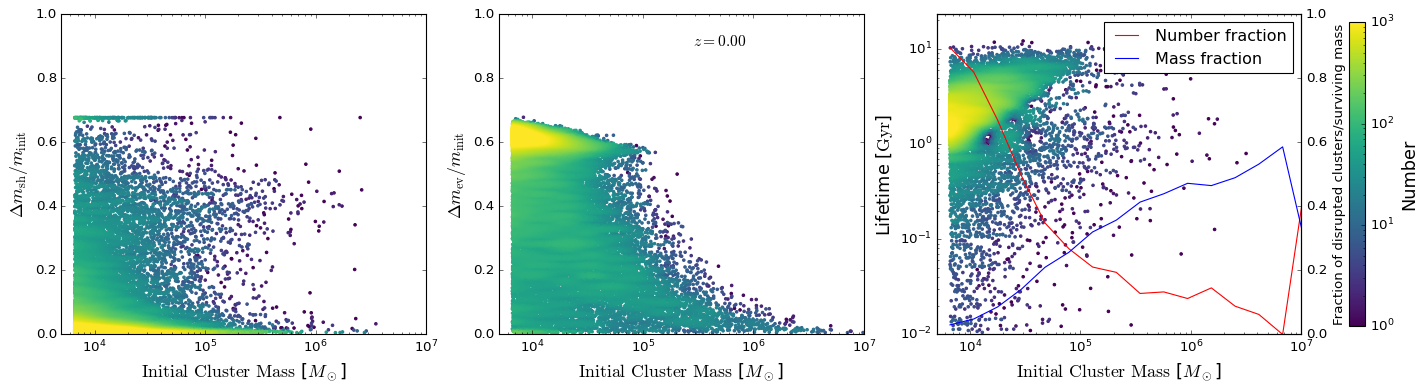

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(mclus_i, mlsh/mclus_i, vmin=1e0, vmax=1e3, ax=ax[0],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[0].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[0].set_ylabel(r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$', fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1], cb1 = density_scatter(mclus_i, mlrx/mclus_i, vmin=1e0, vmax=1e3, ax=ax[1],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].text(5e5, 0.9, r'$z={:.2f}$'.format(s.redshift), fontsize=14, ha='center')
ax[1].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[1].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[1].set_ylabel(r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$', fontsize=16)
ax[1].tick_params(labelsize=12)

ax[2], cb = density_scatter(mclus_i, np.repeat(stars_age,s.data['incl'][starparts]) - drpt_t, vmin=1e0, vmax=1e3, ax=ax[2], bins=[10**marray_icmf, np.logspace(-2,1.5,100)], edgecolors='face', s=5)
ax[2].set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 2.3e1))
ax[2].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[2].set_ylabel(r'Lifetime [$\rm{Gyr}$]', fontsize=16)
ax[2].tick_params(labelsize=12)
ax2 = ax[2].twinx()
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, fraction, color='r', label='Number fraction')
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, massfraction, color='b', label='Mass fraction')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Fraction of disrupted clusters/surviving mass')
ax2.legend()
cbar_ax = fig.add_axes([.93, 0.12, 0.01, 0.76])
cbar = fig.colorbar(cb, cax=cbar_ax)
cbar.set_label('Number', size=16)

In [131]:
element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
#from Asplund et al. (2009) Table 5
SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
for iel,val in enumerate(element):
    s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
    s.data[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

s.data['Z/H'] = np.log10(s.data['gz']/0.0127)

/tmp/ipykernel_1044183/1632773268.py:6: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_1044183/1632773268.py:9: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


In [132]:
m31_metallicity = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=8, delimiter=',')
mw_metallicity = mw_catalogue[:,0]

maskbaryons = s.data['type'][(s.data['type'] == 4) | (s.data['type'] == 0)] == 4
feh_scs = np.repeat(s.data['Fe/H'][maskbaryons][starparts], s.data['nclt'][starparts])
feh_scs_i = np.repeat(s.data['Fe/H'][maskbaryons][starparts], s.data['incl'][starparts])
zh_scs = np.repeat(s.data['Z/H'][maskbaryons][starparts], s.data['nclt'][starparts])
zh_scs_i = np.repeat(s.data['Z/H'][maskbaryons][starparts], s.data['incl'][starparts])

gc_cand_i = (mclus_i > 1e5) * (labels_i == sph_label)
gc_cand_6 = (mclus_i[mclus_m>0] > 1e5) * (labels == sph_label) *(clus_age > 6.)
gc_cand_10 = (mclus_i[mclus_m>0] > 1e5) * (labels == sph_label) *(clus_age > 10.)

Text(0, 0.5, '$\\rm{d}N_{\\rm{GC}} \\, / \\, \\rm{d} [\\rm{Fe/H}]$')

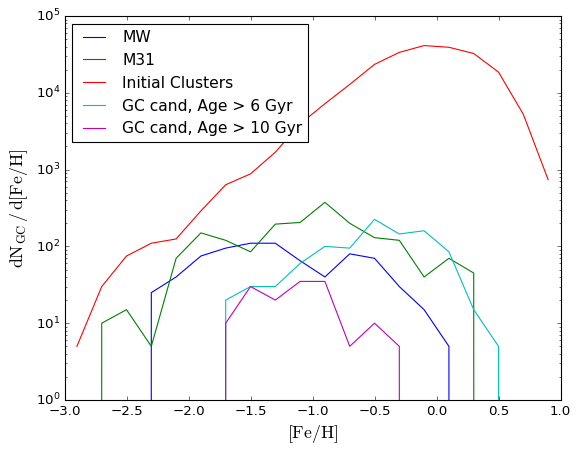

In [133]:
N, binw = np.histogram(mw_metallicity, bins=20, range=[-3,1])
width = np.diff(binw)
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='MW')
N, binw = np.histogram(m31_metallicity, bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='M31')
N,binw = np.histogram(feh_scs_i, bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='Initial Clusters')
N,binw = np.histogram(feh_scs[gc_cand_6], bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='GC cand, Age > 6 Gyr')
N,binw = np.histogram(feh_scs[gc_cand_10], bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='GC cand, Age > 10 Gyr')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel(r'$\rm{[Fe/H]}$', fontsize=16)
plt.ylabel(r'$\rm{d}N_{\rm{GC}} \, / \, \rm{d} [\rm{Fe/H}]$', fontsize=16)

In [134]:
if 'tlij' in s.data.keys():
    tensor = s.data['ttij'] + s.data['tlij']
else:
    tensor = s.data['ttij']

TT_gas = tensor[s.data['type']==0][s.data['sfr']>0] / s.parameters['UnitTime_in_s']**2 * gyr**2
finite_mask_g = np.isfinite(TT_gas).all(axis=1)
TT_gas = TT_gas[finite_mask_g]
TT_star = tensor[s.data['type']==4][starparts][(stars_age<0.05)] / s.parameters['UnitTime_in_s']**2 * gyr**2
finite_mask_s = np.isfinite(TT_star).all(axis=1)
TT_star = TT_star[finite_mask_s]

TT_gas_lambda = np.linalg.eigvalsh(TT_gas.reshape(len(TT_gas),3,3))
TT_gas_lambda = np.sort(TT_gas_lambda, axis=1)
TT_star_lambda = np.linalg.eigvalsh(TT_star.reshape(len(TT_star),3,3))
TT_star_lambda = np.sort(TT_star_lambda, axis=1)

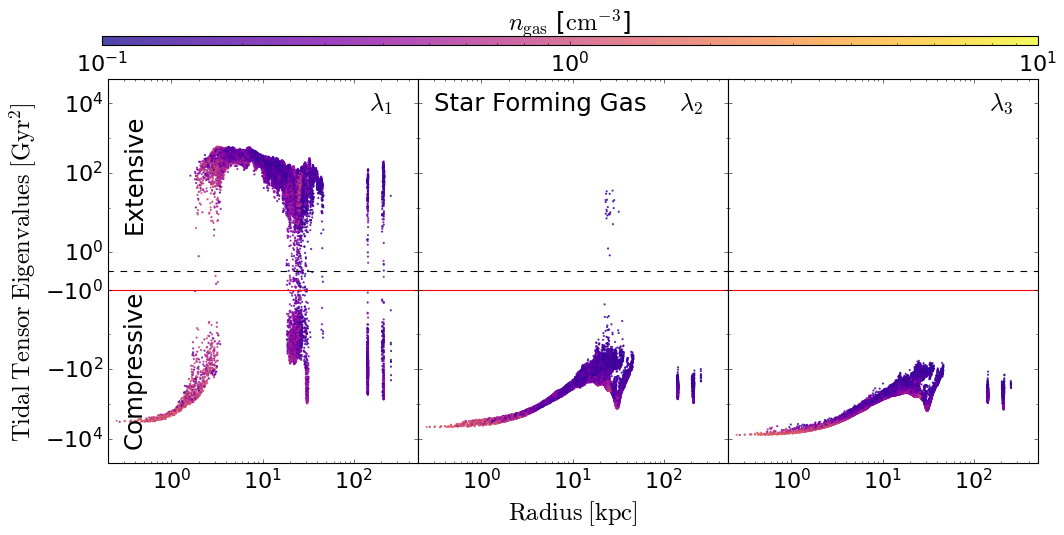

In [135]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15,6))

for idx, axes in enumerate(ax):
    cb = axes.scatter(s.r()[s.data['type']==0][s.data['sfr']>0][finite_mask_g]*1e3, TT_gas_lambda[:,-1-idx], c=s.data['rho'][s.data['sfr']>0][finite_mask_g] *density_units / 1.6726e-24, edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-5e4, 5e4), xscale='log', xlim=(2e-1, 5e2))
    # axes.set(yscale='symlog', xscale='log')
    axes.tick_params(axis='both', which='both', labelsize=20)

ax[0].yaxis.set_major_locator(ticker.FixedLocator([-1e4, -1e2, -1e0, 1e0, 1e2, 1e4]))
ax[0].text(4e-1, 1e2, 'Extensive', fontsize=22, color='k', rotation=90, ha='center', va='center')
ax[0].text(4e-1, -1e2, 'Compressive', fontsize=22, color='k', rotation=90, ha='center', va='center')

ax[0].text(2e2, 1e4, r'$\lambda_1$', fontsize=22, color='k', rotation=0, ha='center', va='center')
ax[1].text(2e2, 1e4, r'$\lambda_2$', fontsize=22, color='k', rotation=0, ha='center', va='center')
ax[2].text(2e2, 1e4, r'$\lambda_3$', fontsize=22, color='k', rotation=0, ha='center', va='center')

ax[1].text(3e-1, 1e4, 'Star Forming Gas', fontsize=22, color='k', ha='left', va='center')

ax[0].set_ylabel(r'$\rm{Tidal\; Tensor\; Eigenvalues\; [Gyr^2]}$', fontsize=22)
ax[1].set_xlabel(r'$\rm{Radius\; [kpc]}$', fontsize=22)

cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.97, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=22)
cbar.ax.tick_params(labelsize=20)
# cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
# cbar.set_label(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=22)

plt.subplots_adjust(wspace=0.0)
# plt.savefig('./plots/TTgas_eigenvalues_paper.pdf', bbox_inches='tight')

In [68]:
sim1_things = [s.r()[s.data['type']==0][s.data['sfr']>0][finite_mask_g]*1e3, TT_gas_lambda, s.data['rho'][s.data['sfr']>0][finite_mask_g] *density_units / 1.6726e-24,
               s.data['id'][s.data['type']==0][s.data['sfr']>0][finite_mask_g]]

In [136]:
sim2_things = [s.r()[s.data['type']==0][s.data['sfr']>0][finite_mask_g]*1e3, TT_gas_lambda, s.data['rho'][s.data['sfr']>0][finite_mask_g] *density_units / 1.6726e-24,
               s.data['id'][s.data['type']==0][s.data['sfr']>0][finite_mask_g]]

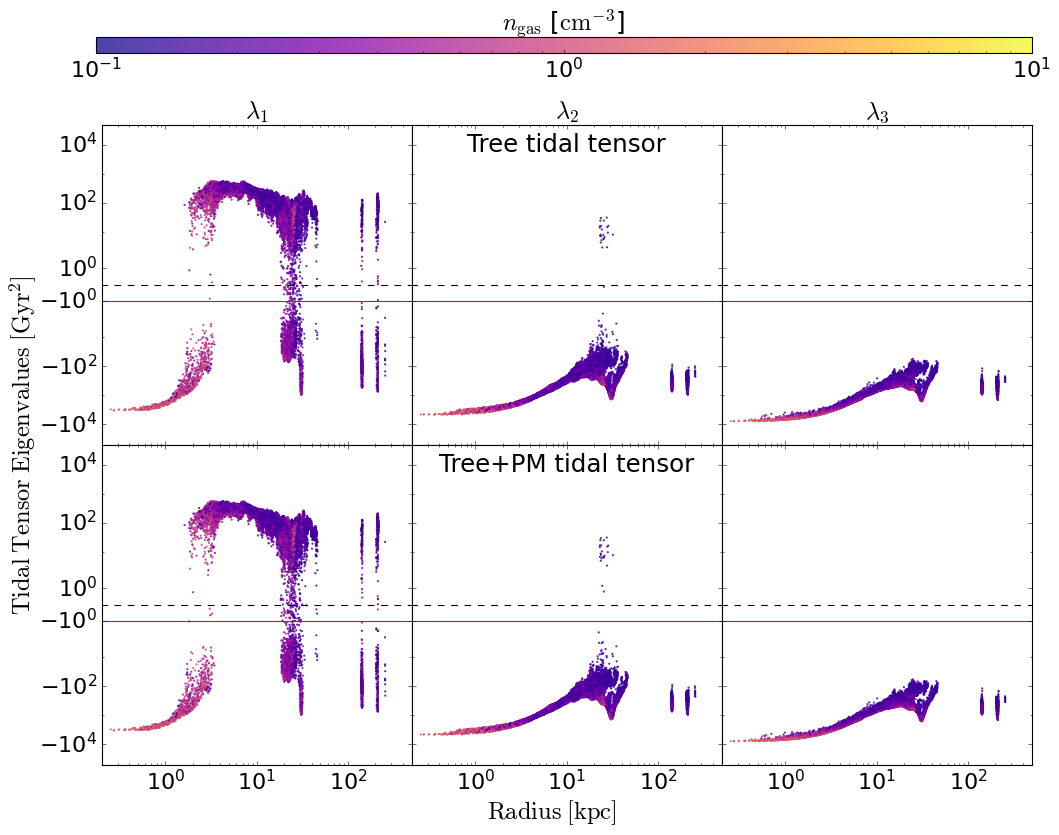

In [137]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(15,10))

for idx, axes in enumerate(ax[0,:]):
    cb = axes.scatter(sim1_things[0], sim1_things[1][:,-1-idx], c=sim1_things[2], edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-5e4, 5e4), xscale='log', xlim=(2e-1, 5e2))
    # axes.set(yscale='symlog', xscale='log')
    axes.tick_params(axis='both', which='both', labelsize=20)
    
for idx, axes in enumerate(ax[1,:]):
    cb = axes.scatter(sim2_things[0], sim2_things[1][:,-1-idx], c=sim2_things[2], edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-5e4, 5e4), xscale='log', xlim=(2e-1, 5e2))
    # axes.set(yscale='symlog', xscale='log')
    axes.tick_params(axis='both', which='both', labelsize=20)

ax[0,0].yaxis.set_major_locator(ticker.FixedLocator([-1e4, -1e2, -1e0, 1e0, 1e2, 1e4]))
ax[1,0].yaxis.set_major_locator(ticker.FixedLocator([-1e4, -1e2, -1e0, 1e0, 1e2, 1e4]))

ax[0,0].set_title(r'$\lambda_1$', fontsize=22)
ax[0,1].set_title(r'$\lambda_2$', fontsize=22)
ax[0,2].set_title(r'$\lambda_3$', fontsize=22)

ax[0,1].text(1e1, 1e4, 'Tree tidal tensor', fontsize=22, color='k', ha='center', va='center')
ax[1,1].text(1e1, 1e4, 'Tree+PM tidal tensor', fontsize=22, color='k', ha='center', va='center')

fig.text(0.06, 0.5, r'$\rm{Tidal\; Tensor\; Eigenvalues\; [Gyr^2]}$', fontsize=22, ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, r'$\rm{Radius\; [kpc]}$', fontsize=22, ha='center', va='center')

cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.99, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=22)
cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('./plots/tteig_compare_paper.pdf', bbox_inches='tight')

In [140]:
np.sum(~sim1_things[-1]==sim2_things[-1])

np.int64(0)

0.06981213780754855
-0.134720763695563
nan


/users/aripcont/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/aripcont/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


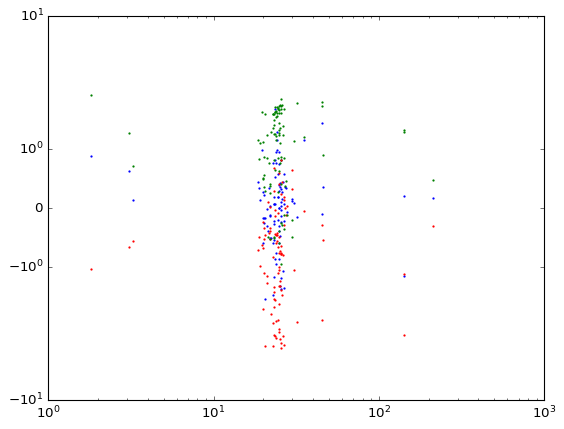

In [177]:
for idx in range(3):
    mask_highdiff = np.abs(np.abs(sim1_things[1][:,-1-idx] - sim2_things[1][:,-1-idx])/sim1_things[1][:,-1-idx])> 1
    print(np.median(sim1_things[1][:,-1-idx][mask_highdiff]))

    plt.scatter(sim1_things[0][mask_highdiff], sim1_things[1][:,-1-idx][mask_highdiff], c='b', edgecolors='face',s=1)
    plt.scatter(sim2_things[0][mask_highdiff], sim2_things[1][:,-1-idx][mask_highdiff], c='r', edgecolors='face',s=1)
    plt.scatter(sim2_things[0][mask_highdiff], sim1_things[1][:,-1-idx][mask_highdiff] - sim2_things[1][:,-1-idx][mask_highdiff], c='g', edgecolors='face',s=1)
    plt.xscale('log')
    plt.yscale('symlog')

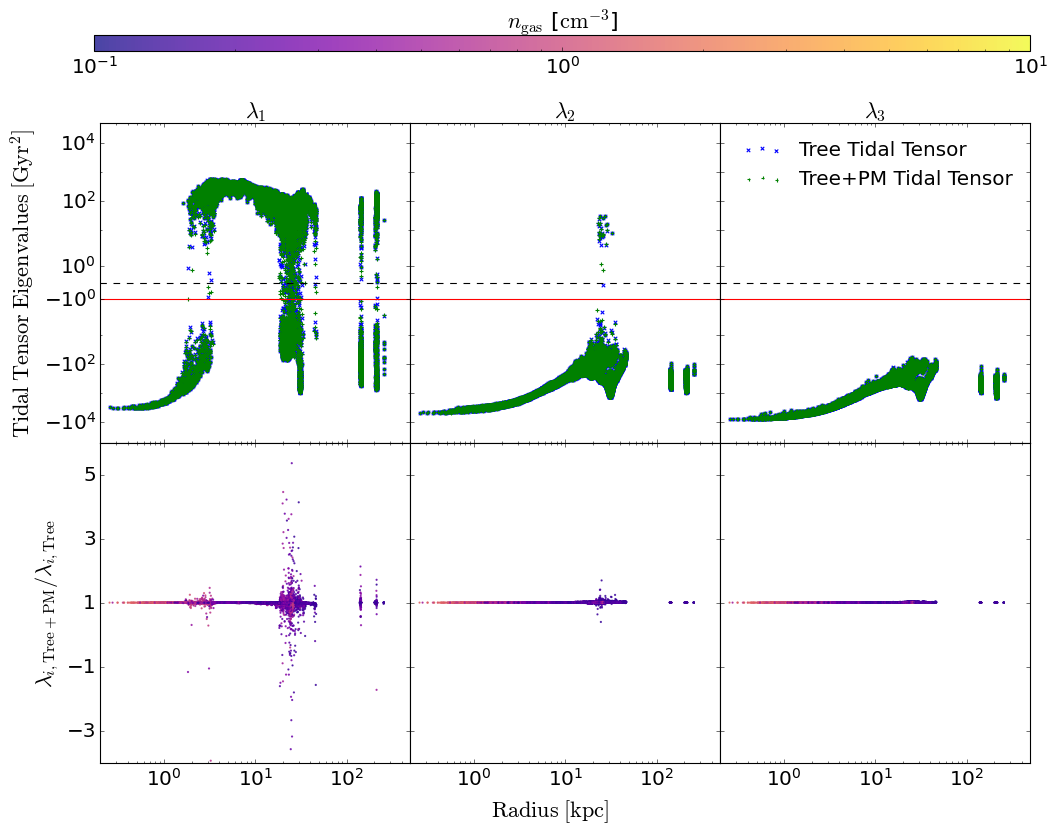

In [221]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(15,10))

for idx, axes in enumerate(ax[0,:]):
    cb = axes.scatter(sim1_things[0], sim1_things[1][:,-1-idx], c='b', marker='x',\
                      s=10, rasterized=True, label='Tree Tidal Tensor')
    cb = axes.scatter(sim1_things[0], sim2_things[1][:,-1-idx], c='g', marker='+',\
                      s=10, rasterized=True, label='Tree+PM Tidal Tensor')
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-5e4, 5e4), xscale='log', xlim=(2e-1, 5e2))
    # axes.set(yscale='symlog', xscale='log')
    axes.tick_params(axis='both', which='both', labelsize=18)
    if idx!=0:
        axes.set_yticklabels([])

ax[0,2].legend(loc='upper right', frameon=False, fontsize=18, scatterpoints=3)
    
for idx, axes in enumerate(ax[1,:]):
    cb = axes.scatter(sim2_things[0], sim2_things[1][:,-1-idx]/sim1_things[1][:,-1-idx],\
                      c=sim2_things[2], edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
    # axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    # axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(xscale='log', xlim=(2e-1, 5e2))
    # axes.set_yscale('symlog')#, linthresh=1.)
    axes.set_ylim(-4,6)
    axes.tick_params(axis='both', which='both', labelsize=18)
    axes.set_yticks(np.arange(-3,7,2))
    if idx!=0:
        axes.set_yticklabels([])

ax[0,0].yaxis.set_major_locator(ticker.FixedLocator([-1e4, -1e2, -1e0, 1e0, 1e2, 1e4]))
ax[0,0].set_ylabel(r'$\rm{Tidal\; Tensor\; Eigenvalues\; [Gyr^2]}$', fontsize=20)
# ax[1,0].yaxis.set_major_locator(ticker.FixedLocator([-1e4, -1e2, -1e0, 1e0, 1e2, 1e4]))
ax[1,0].set_ylabel(r'$\lambda_{i, \mathrm{Tree+PM}} / \lambda_{i, \mathrm{Tree}}$', fontsize=20)

ax[0,0].set_title(r'$\lambda_1$', fontsize=20)
ax[0,1].set_title(r'$\lambda_2$', fontsize=20)
ax[0,2].set_title(r'$\lambda_3$', fontsize=20)

# ax[0,1].text(1e1, 1e4, 'Tree tidal tensor', fontsize=20, color='k', ha='center', va='center')
# ax[1,1].text(1e1, 1e4, 'Tree+PM tidal tensor', fontsize=20, color='k', ha='center', va='center')

# fig.text(0.06, 0.5, r'$\rm{Tidal\; Tensor\; Eigenvalues\; [Gyr^2]}$', fontsize=20, ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, r'$\rm{Radius\; [kpc]}$', fontsize=20, ha='center', va='center')

cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.99, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('./plots/tteig_compare_paper.pdf', bbox_inches='tight')

/tmp/ipykernel_1645202/1367119359.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1200x480 with 4 Axes> than <Figure size 1440x400 with 4 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))


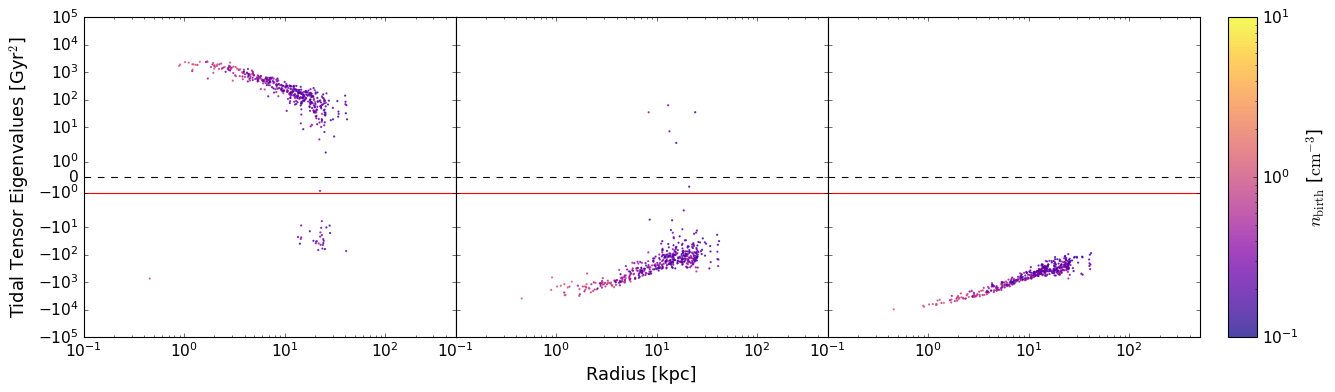

In [68]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))

for idx, axes in enumerate(ax):
    axes.scatter(s.r()[s.data['type']==4][starparts][stars_age<0.05][finite_mask_s]*1e3, TT_star_lambda[:,-1-idx], c=s.data['bdens'][starparts][stars_age<0.05][finite_mask_s]*density_units/1.6726e-24,\
                  edgecolors='face', s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma')
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-1e5, 1e5), xscale='log', xlim=(1e-1, 5e2))
    axes.tick_params(axis='both', which='both', labelsize=14)

ax[0].set_ylabel(r'Tidal Tensor Eigenvalues [Gyr$^2$]', fontsize=16)
ax[1].set_xlabel('Radius [kpc]', fontsize=16)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label(r'$n_{\rm{birth}}$ [$\rm{cm}^{-3}$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.0)

In [174]:
def get_circular_frequency(s, radial_bins):
    enclosed_mass = np.zeros_like(radial_bins)
    for i, r in enumerate(radial_bins):
        mask = (1e3*s.r()<r)
        enclosed_mass[i] = s.data['mass'][mask].sum() * s.parameters['UnitMass_in_g']
    return np.sqrt(Gcgs*enclosed_mass / (radial_bins*1e3*parsec)**3)

def get_enclosed_mean_density(s, radial_bins):
    enclosed_mass = np.zeros_like(radial_bins)
    for i, r in enumerate(radial_bins):
        mask = (1e3*s.r()<r)
        enclosed_mass[i] = s.data['mass'][mask].sum() * s.parameters['UnitMass_in_g']
    volume = (4/3.) * np.pi * (radial_bins*1e3*parsec)**3
    return enclosed_mass / volume

def get_disc_mean_density(s, radial_bins):
    enclosed_mass = np.zeros_like(radial_bins)
    for i, r in enumerate(radial_bins):
        mask = (1e3*s.r()<r)
        enclosed_mass[i] = s.data['mass'][mask].sum() * s.parameters['UnitMass_in_g']
    volume = (4/3.) * np.pi * (radial_bins*1e3*parsec)**3
    return enclosed_mass / volume

def get_epicyclic_frequency(s, radial_bins):
    omega2 = get_circular_frequency(s, radial_bins)**2
    dOmega2_dR = np.gradient(omega2, radial_bins*1e3*parsec)
    kappa = np.sqrt(radial_bins*parsec*1e3 * dOmega2_dR + 4*omega2)
    return kappa

In [175]:
enclosed_rho_star = np.abs(np.sum(TT_star_lambda, axis=1)/gyr**2.) / (4 * np.pi * Gcgs) * parsec**3 / solar_mass_g
omega2_star = 0.3333 * np.abs((TT_star_lambda).sum(axis=1))
kappa2_star = np.abs(3*(omega2_star) - TT_star_lambda[:,2])

enclosed_rho_gas = np.abs(np.sum(TT_gas_lambda, axis=1)/gyr**2.) / (4 * np.pi * Gcgs) * parsec**3 / solar_mass_g
omega2_gas = 0.3333 * np.abs((TT_gas_lambda).sum(axis=1))
kappa2_gas = np.abs(3*(omega2_gas) - TT_gas_lambda[:,2])

radial_bins = np.logspace(-1, 2.7, 100) # in kpc
enclosed_mean_rho_radial = get_enclosed_mean_density(s, radial_bins) * parsec**3 / solar_mass_g
omega_radial = get_circular_frequency(s, radial_bins) * gyr
kappa_radial = get_epicyclic_frequency(s, radial_bins) * gyr

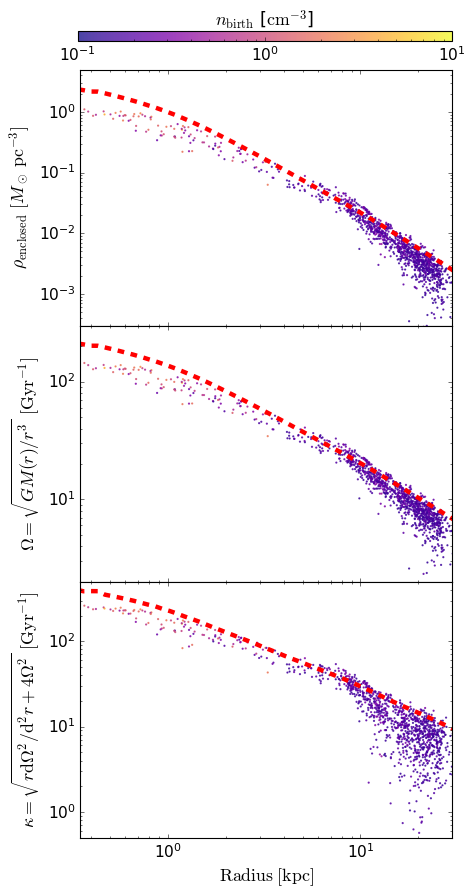

In [179]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 12))
cb = ax[0].scatter(s.r()[s.data['type']==4][starparts][stars_age<0.05]*1e3, enclosed_rho_star, c=s.data['bdens'][starparts][stars_age<0.05]*density_units/1.6726e-24,\
                  edgecolors='face', s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
ax[0].plot(radial_bins, enclosed_mean_rho_radial, 'r--', linewidth=4, label='Mean Field')
ax[0].set(xscale='log', yscale='log', xlim=(3.5e-1, 3e1), ylim=(3e-4, 5e0))
ax[0].set_ylabel(r'$\rho_{\rm{enclosed}}$ $[M_\odot \; \rm{pc}^{-3}]$', fontsize=16)
ax[0].tick_params(labelsize=14)
# ax[0].set_xlabel(r'$\mathrm{Radius \; [kpc]}$', fontsize=16)
cb = ax[1].scatter(s.r()[s.data['type']==4][starparts][stars_age<0.05]*1e3, np.sqrt(omega2_star), c=s.data['bdens'][starparts][stars_age<0.05]*density_units/1.6726e-24,\
                  edgecolors='face', s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
ax[1].plot(radial_bins, omega_radial, 'r--', linewidth=4, label='Mean Field')
ax[1].set(xscale='log', yscale='log', xlim=(3.5e-1, 3e1), ylim=(2e0, 3e2))
ax[1].set_ylabel(r'$\Omega=\sqrt{GM(r)/r^3}$ $[\rm{Gyr}^{-1}]$', fontsize=16)
ax[1].tick_params(labelsize=14)
# ax[1].set_xlabel(r'$\mathrm{Radius \; [kpc]}$', fontsize=16)
cb = ax[2].scatter(s.r()[s.data['type']==4][starparts][stars_age<0.05]*1e3, np.sqrt(kappa2_star), c=s.data['bdens'][starparts][stars_age<0.05]*density_units/1.6726e-24,\
                  edgecolors='face', s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
ax[2].plot(radial_bins, kappa_radial, 'r--', linewidth=4, label='Mean Field')
ax[2].set(xscale='log', yscale='log', xlim=(3.5e-1, 3e1), ylim=(5e-1, 5e2))
ax[2].set_ylabel(r'$\kappa = \sqrt{r \mathrm{d}\Omega^2/\mathrm{d}^2r + 4\Omega^2}$ $[\rm{Gyr}^{-1}]$', fontsize=16)
ax[2].set_xlabel(r'$\mathrm{Radius \; [kpc]}$', fontsize=16)
ax[2].tick_params(labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.93, 0.78, 0.01]), orientation='horizontal')
cbar.ax.set_title(r'$n_{\rm{birth}}$ [$\rm{cm}^{-3}$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.subplots_adjust(hspace=0.)
plt.savefig('plots/frequencies_estimate_paper.pdf', bbox_inches='tight')

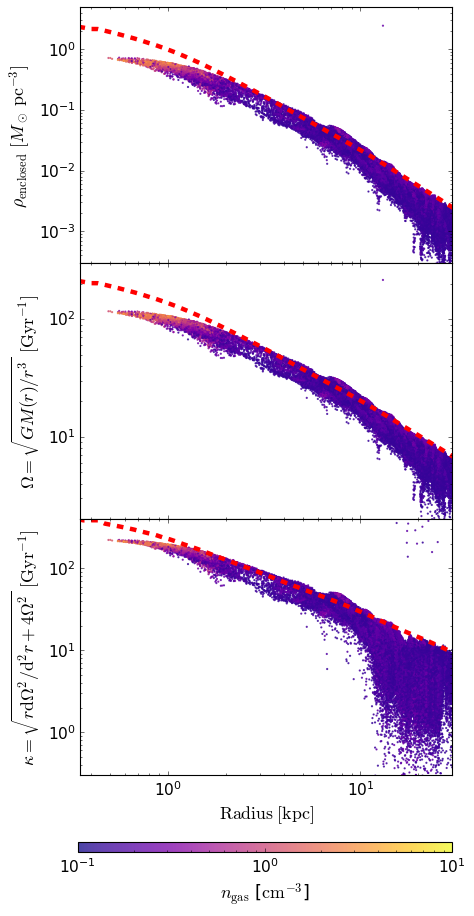

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 12))
cb = ax[0].scatter(s.r()[s.data['type']==0][s.data['sfr']>0]*1e3, enclosed_rho_gas, c=s.data['rho'][s.data['sfr']>0] *density_units / 1.6726e-24, edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
ax[0].plot(radial_bins, enclosed_mean_rho_radial, 'r--', linewidth=4, label='Mean Field')
ax[0].set(xscale='log', yscale='log', xlim=(3.5e-1, 3e1), ylim=(3e-4, 5e0))
ax[0].set_ylabel(r'$\rho_{\rm{enclosed}}$ $[M_\odot \; \rm{pc}^{-3}]$', fontsize=16)
ax[0].tick_params(labelsize=14)
# ax[0].set_xlabel(r'$\mathrm{Radius \; [kpc]}$', fontsize=16)
cb = ax[1].scatter(s.r()[s.data['type']==0][s.data['sfr']>0]*1e3, np.sqrt(omega2_gas), c=s.data['rho'][s.data['sfr']>0] *density_units / 1.6726e-24, edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
ax[1].plot(radial_bins, omega_radial, 'r--', linewidth=4, label='Mean Field')
ax[1].set(xscale='log', yscale='log', xlim=(3.5e-1, 3e1), ylim=(2e0, 3e2))
ax[1].set_ylabel(r'$\Omega=\sqrt{GM(r)/r^3}$ $[\rm{Gyr}^{-1}]$', fontsize=16)
ax[1].tick_params(labelsize=14)
# ax[1].set_xlabel(r'$\mathrm{Radius \; [kpc]}$', fontsize=16)
cb = ax[2].scatter(s.r()[s.data['type']==0][s.data['sfr']>0]*1e3, np.sqrt(kappa2_gas), c=s.data['rho'][s.data['sfr']>0] *density_units / 1.6726e-24, edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma', rasterized=True)
ax[2].plot(radial_bins, kappa_radial, 'r--', linewidth=4, label='Mean Field')
ax[2].set(xscale='log', yscale='log', xlim=(3.5e-1, 3e1), ylim=(3e-1, 4e2))
ax[2].set_ylabel(r'$\kappa = \sqrt{r \mathrm{d}\Omega^2/\mathrm{d}^2r + 4\Omega^2}$ $[\rm{Gyr}^{-1}]$', fontsize=16)
ax[2].set_xlabel(r'$\mathrm{Radius \; [kpc]}$', fontsize=16)
ax[2].tick_params(labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.02, 0.78, 0.01]), orientation='horizontal')
cbar.set_label(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.subplots_adjust(hspace=0.)
# plt.savefig('plots/frequencies_estimate.pdf', bbox_inches='tight')

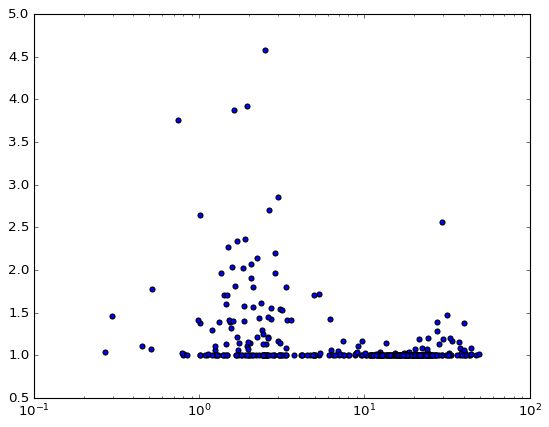

In [73]:
plt.scatter(s.r()[s.data['type']==4][starparts][(stars_age<0.5)*mask_cluster_initial]*1e3, s.data['bphi'][starparts][(stars_age<0.5)*mask_cluster_initial])
plt.xscale('log')

Text(0, 0.5, '$\\Gamma$')

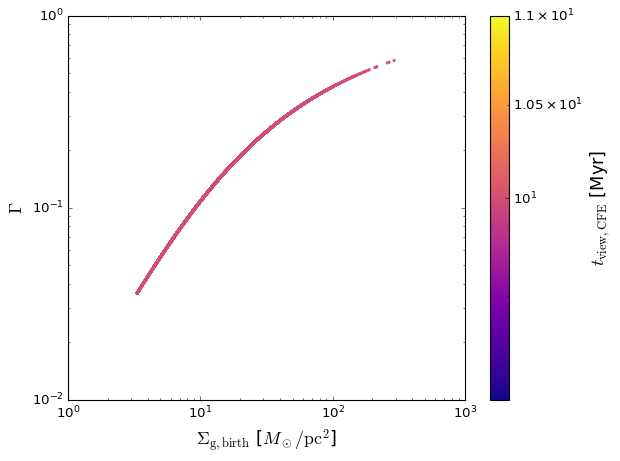

In [74]:
plt.scatter(s.data['bsig'][starparts][mask_cluster_initial] * surface_dens_units * parsec**2/solar_mass_g, s.data['lcfe'][starparts][mask_cluster_initial], \
            c=s.data['tcfe'][starparts][mask_cluster_initial]/3.15576e13, edgecolors='face', norm=mcolors.LogNorm(), cmap='plasma', s=3)
cb = plt.colorbar()
cb.set_label(label=r'$t_{\rm{view, CFE}}$ [Myr]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Sigma_{\rm{g, birth}}$ [$M_\odot/\rm{pc}^2$]', fontsize=16)
plt.ylabel(r'$\Gamma$', fontsize=16)

Disrupted GCs: 230  of  989


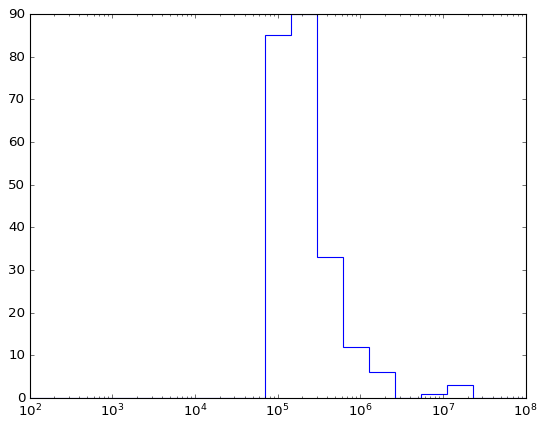

In [75]:
print('Disrupted GCs:', np.sum((mclus_i>1e5) * (labels_i==sph_label) * (mclus_m < 1e2)), ' of ', np.sum((mclus_i>1e5) * (labels_i==sph_label)))

plt.hist(mclus_i[(mclus_i>1e5) * (labels_i==sph_label) * (mclus_m < 1e2)], bins=np.logspace(2, 8, 20), histtype='step', label='GCs')
plt.xscale('log')

In [76]:
halomass_gcmass_rel = np.genfromtxt('catalogues_compare/halo_gc_relation.txt', delimiter=',')

In [77]:
halobins = np.linspace(6.5, 14.5, 10)
halomass_gcmass_rel[halomass_gcmass_rel<3.5]=0.0
median_relation = []
sigma_low_relation = []
sigma_high_relation = []
for i in range(len(halobins)-1):
    mask = (halomass_gcmass_rel[:,0] > halobins[i]) & (halomass_gcmass_rel[:,0] < halobins[i+1])
    median_relation.append(np.median(halomass_gcmass_rel[mask,1]))
    sigma_low_relation.append(np.percentile(halomass_gcmass_rel[mask,1], 2.3))
    sigma_high_relation.append(np.percentile(halomass_gcmass_rel[mask,1], 97.7))

median_relation = np.array(median_relation)
sigma_low_relation = np.array(sigma_low_relation)
sigma_high_relation = np.array(sigma_high_relation)

In [78]:
np.log10(sf.data['fmm2'][0]*1e10)

np.float32(12.02313)

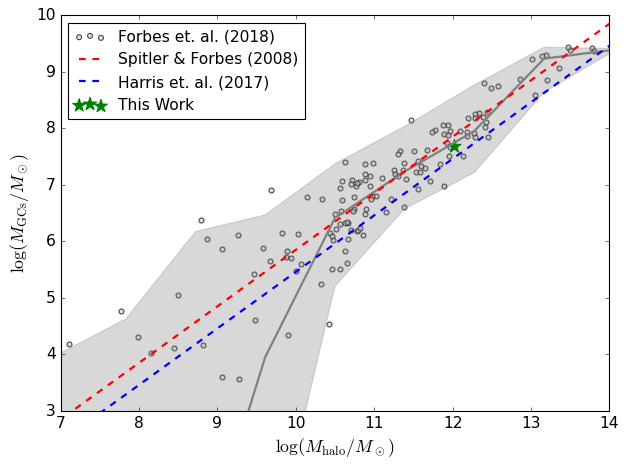

In [79]:
plt.scatter(halomass_gcmass_rel[:,0], halomass_gcmass_rel[:,1], c='lightgrey', label='Forbes et. al. (2018)', alpha=0.7)
plt.plot((halobins[1:]+halobins[:-1])/2., median_relation, color='grey', linewidth=2)
plt.fill_between((halobins[1:]+halobins[:-1])/2., sigma_low_relation, sigma_high_relation, color='grey', alpha=0.3)
plt.plot(halobins, halobins - 4.15, color='r', linewidth=2, linestyle='dashed', label='Spitler & Forbes (2008)')
plt.plot(halobins, halobins - 4.54, color='b', linewidth=2, linestyle='dashed', label='Harris et. al. (2017)')
plt.scatter(np.log10(sf.data['fmm2'][0]*1e10), np.log10(mclus_m[(mclus_i>1e5) * (labels_i==sph_label) * (clus_age_i>6.)].sum()), marker='*', color='g', s=150, label='This Work')
plt.xlim(7, 14)
plt.ylim(3, 10)
plt.xlabel(r'$\log(M_{\rm{halo}}/M_\odot)$', fontsize=16)
plt.ylabel(r'$\log(M_{\rm{GCs}}/M_\odot)$', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
# plt.savefig('./plots/halomass_gcmass_relation_paper.pdf', bbox_inches='tight')

In [8]:
treepath = parent_dir+simulation_list[sim_id]+'/trees/'
t = load_tree(0, 0, base=treepath+'trees_sf1_%03d' % snap_id, verbose=False)
"""Some of the quantities are automatically transformed at this step"""

'Some of the quantities are automatically transformed at this step'

In [ ]:
snap_numbers_main,redshifts_main,subfind_indices_main,first_progs_indices_main,ff_tree_indices_main,fof_indices_main,prog_mass_main,next_prog_indices = t.return_first_next_mass_progenitors(0)
print('snap_numbers_main,redshifts_main=',snap_numbers_main,redshifts_main)
print('subfind_indices_main,fof_indices_main=',subfind_indices_main,fof_indices_main)

snap_numbers_main,redshifts_main= [127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110
 109 108 107 106 105 104 103 102 101 100  99  98  97  96  95  94  93  92
  91  90  89  88  87  86  85  84  83  82  81  80  79  78  77  76  75  74
  73  72  71  70  69  68  67  66  65  64  63  62  61  60  59  58  57  56
  55  54  53  52  51  50  49  48  47  46  45  44  43  42  41  40  39  38
  37  36  35  34  33  32  31  30  29  28  27  26  25  24  23  22  21  20
  19  18] [2.22044605e-16 9.52166691e-03 2.39744280e-02 3.37243713e-02
 4.85236309e-02 5.85073233e-02 7.36613870e-02 8.38844329e-02
 9.94018018e-02 1.09869942e-01 1.25759333e-01 1.41876206e-01
 1.52748764e-01 1.69252038e-01 1.80385262e-01 1.97284177e-01
 2.14425042e-01 2.25988388e-01 2.43540183e-01 2.61343271e-01
 2.73353338e-01 2.91583240e-01 3.10074121e-01 3.28829736e-01
 3.47853839e-01 3.60687643e-01 3.80167872e-01 3.99926960e-01
 4.19968933e-01 4.40297842e-01 4.60917801e-01 4.81832951e-01
 5.03047526e-01 5.24565816e-01

In [ ]:
"""Read the accreted particle files with a gadget_readsnap() method"""

list_directory = './lists/accretedstardata/%s/'%simulation_list[sim_id]
s.read_starparticle_mergertree_data_hdf5(snap_id, list_directory,'')
print(s.mdata)

1243210 in-situ and 134233 ex-situ stars found
{'Insitu': {'Npart': np.int64(1243210), 'ParticleIDs': array([8796103092592, 8796103103017, 8796097567455, ..., 8796151453313,
       8796157324225, 8796158545672], shape=(1243210,), dtype=uint64)}, 'Exsitu': {'Npart': np.int64(134233), 'AccretedFlag': array([0, 0, 1, ..., 1, 1, 1], shape=(134233,), dtype=int32), 'BirthFoFindex': array([16, 11,  8, ...,  0,  0,  0], shape=(134233,), dtype=int32), 'BirthSubhaloindex': array([ 16,  18, 408, ...,   1,   1,   1], shape=(134233,), dtype=int32), 'ParticleIDs': array([8796088183805, 8796088189736, 6814655006951, ..., 8796160929001,
       8796160951958, 8796160968782], shape=(134233,), dtype=uint64), 'PeakMassIndex': array([31310,  5356,   491, ...,   491,   491,   491],
      shape=(134233,), dtype=int32), 'RootIndex': array([131162,  10164,  12514, ...,    491,    491,    491],
      shape=(134233,), dtype=int32), 'BoundFirstTime': array([10.690971 ,  4.4169116, -1.       , ..., -1.       , -1.

In [ ]:
"""Count the number of star particles that are now bound to the main halo from each progenitor system, and sort in descending order of mass"""
first_prog, nstars_in_subhalo = np.unique(s.mdata['Exsitu']['PeakMassIndex'], return_counts=True)
nstars_in_subhalo = nstars_in_subhalo[first_prog >= 0]
first_prog = first_prog[first_prog >= 0]  # remove -1 entries
mass_order = np.argsort(nstars_in_subhalo)[::-1]
first_prog = first_prog[mass_order]
nstars_in_subhalo = nstars_in_subhalo[mass_order]

print('finished finding stars for each progenitor.')
print('first_prog=',first_prog,len(first_prog))
print('nstars_in_subhalo=',nstars_in_subhalo)

finished finding stars for each progenitor.
first_prog= [   491  10541   5356  13667  19387  10262  17820    478  10554  19750
  19389    862  18324  20094   4565  18549   7670 244952  31310  19936
   2660] 21
nstars_in_subhalo= [72924 13927 10944 10403  7893  5261  4989  3841  1426   602   537   117
    70    44    20    17    12     2     1     1     1]


In [9]:
def ReturnFullBranchGivenTreeIndex(tree, tree_id, truncate_mainbranch=True, order_backwards=True):

        indices = []

        # First go up the tree (main progenitor branch)
        index = tree_id
        while tree.data['fpin'][index] != -1:
            index = tree.data['fpin'][index]

        # then go down (descendant)
        while index != -1:
            indices.append(index)
            index = tree.data['desc'][index]

        # this removes the part of the branch corresponding to the main MW-analogue indices (i.e. after an object merges with the MW), leaving us with only the pre-merged part of the branch (i.e. the objects tree indices prior to merging with the MW)
        if truncate_mainbranch:
            index = 0
            main_indices = np.array([],dtype=int)
            while tree.data['fpin'][index] != -1:
                main_indices = np.append(main_indices,index)
                index = tree.data['fpin'][index]
            mask, = np.where(np.isin(indices,main_indices)==False)
            indices = indices[mask]

        # it true, reverse the list so that the latest time appears as the first index in the list
        if order_backwards:
            indices.reverse()

        return np.array(indices)

def GetProgenitorInfallIndex(tree, tree_id, verbose=False):
    indices_main = ReturnFullBranchGivenTreeIndex(tree, 0, truncate_mainbranch=False, order_backwards=True)
    indices_object = ReturnFullBranchGivenTreeIndex(tree, tree_id, truncate_mainbranch=False, order_backwards=True)
    
    snaps_main = tree.data['snum'][indices_main]
    snaps_object = tree.data['snum'][indices_object]

    # Find common snaps
    index_common, index_com_object, index_com_main = np.intersect1d(snaps_object, snaps_main, return_indices=True)

    distance = np.sqrt( np.sum( (tree.data['spos'][indices_object[index_com_object]] - tree.data['spos'][indices_main[index_com_main]])**2, axis=1))
    i, = np.where( distance < tree.data['frc2'][indices_main[index_com_main]] )
    if verbose:
        print('distance=',distance,len(distance))
        print('R200=',tree.data['frc2'][indices_main[index_com_main]])
        print('i=',i)
        print(indices_object[index_com_object])
        print('indy=',indices_object[index_com_object[i]])
    if len(i):
        infall_index = indices_object[index_com_object[i[0]]]
        infall_index_main = indices_main[index_com_main[i[0]]]

        ii = -1
        prev_snap = snaps_object[index_com_object[i[0]]] - 1
        while infall_index == infall_index_main:
            if verbose:
                print('We have reached the beginning of this progenitor branch and cannot identify the infall time, likely because it becomes unbound before crossing R200. We iterate backwards through the progenitor branch to the first time it appears bound.')
            newindex = i[0] + ii
            if newindex>=0:
                if verbose:
                    print('i[0]', i[0], 'newindex=', newindex, 'snap i[0]=', snaps_object[index_com_object[i[0]]], 'snap newindex=', snaps_object[index_com_object[newindex]])
                try:
                    infall_index = indices_object[index_com_object[newindex]]
                    infall_index_main = indices_main[index_com_main[newindex]]
                    ii -= 1
                except:
                    raise ValueError('We cannot go further backwards on this branch, likely because we are at the beginning of the tree.')
            else:
                if verbose:
                    print('snaps=',snaps_object)
                if (snaps_object == prev_snap).any() and (snaps_object >= prev_snap).any():
                    if verbose:
                        print('Looking for infall at snap=', prev_snap)
                        print('obj', indices_object[snaps_object == prev_snap])
                        print('main', indices_main[snaps_main == prev_snap])
                    infall_index = indices_object[snaps_object == prev_snap]
                    infall_index_main = indices_main[snaps_main == prev_snap]
                elif(snaps_object.min() < prev_snap):
                    if verbose:
                        print('We have reached the beginning of this progenitor branch and cannot identify the infall time. Null result given')
                    infall_index = None
                else:
                    prev_snap -= 1
            # print('We have reached the beginning of this progenitor branch and cannot identify the infall time. Null result given')
            # infall_index = None
            # infall_index_main = None
    else:  
        if verbose:
            print('No infall index found, likely because the object never crosses R200. Null result given')
        infall_index = None
        infall_index_main = None

    return infall_index, infall_index_main

def get_merger_events_gyr_from_tree(simulation, snapshot, minimum_ratio=1./4., treedir='/trees/', verbose=False):
    print('Identifying major merger events for simulation: ', simulation)
    treepath = simulation+treedir
    s = gadget_readsnap(snapshot, snappath=simulation+'/output/', hdf5=True, onlyHeader=True)
    print('Loading merger tree at', treepath)
    t = load_tree(0, 0, base=treepath+'trees_sf1_%03d' % snapshot, verbose=verbose)

    accr_time_infall = []
    idx=0
    while idx != -1:
        if verbose:
            print('Lookbacktime:', s.cosmology_get_lookback_time_from_a(t.data['time'][idx], is_flat=True))
        npin = t.data['npin'][idx]
        while npin != -1:
            infall_index, infall_index_main = GetProgenitorInfallIndex(t, npin, verbose=verbose)
            if infall_index:
                TotalmassRatioAtInfall = t.data['smty'][infall_index].sum() / t.data['smty'][infall_index_main].sum()
                if(TotalmassRatioAtInfall > 1.): TotalmassRatioAtInfall = 1./TotalmassRatioAtInfall
                if(t.data['smty'][infall_index,4] > 0 and t.data['smty'][infall_index_main,4] > 0):
                    StellarmassRatioAtInfall = t.data['smty'][infall_index,4] / t.data['smty'][infall_index_main,4]
                    if(StellarmassRatioAtInfall > 1.): StellarmassRatioAtInfall = 1./StellarmassRatioAtInfall
                else:
                    StellarmassRatioAtInfall = 0.
                if(t.data['smty'][infall_index,0] > 0 and t.data['smty'][infall_index_main,0] > 0):
                    GasmassRatioAtInfall = t.data['smty'][infall_index,0] / t.data['smty'][infall_index_main,0]
                    if(GasmassRatioAtInfall > 1.): GasmassRatioAtInfall = 1./GasmassRatioAtInfall
                else:
                    GasmassRatioAtInfall = 0.
                if (GasmassRatioAtInfall > minimum_ratio and StellarmassRatioAtInfall > 0.) or (StellarmassRatioAtInfall > minimum_ratio):
                    time = s.cosmology_get_lookback_time_from_a(t.data['time'][infall_index], is_flat=True)
                    accr_time_infall.append(time)
                    print('Infall time for this merger' , time)
                    print('TotalmassRatioAtInfall=',TotalmassRatioAtInfall)
                    print('GasmassRatioAtInfall=',GasmassRatioAtInfall)
                    print('StellarmassRatioAtInfall=',StellarmassRatioAtInfall)
                    print('-----------------------------------')

            npin = t.data['npin'][npin]
        
        idx = t.data['fpin'][idx]

    return np.array(accr_time_infall)

In [10]:
accr_time_infall = []
accr_z_infall = []
idx=0
minimum_ratio = 1./20.
while idx != -1:
    # print('Lookbacktime:', s.cosmology_get_lookback_time_from_a(t.data['time'][idx], is_flat=True))
    npin = t.data['npin'][idx]
    while npin != -1:
        infall_index, infall_index_main = GetProgenitorInfallIndex(t, npin, verbose=False)
        if infall_index:
            TotalmassRatioAtInfall = t.data['smty'][infall_index].sum() / t.data['smty'][infall_index_main].sum()
            if(TotalmassRatioAtInfall > 1.): TotalmassRatioAtInfall = 1./TotalmassRatioAtInfall
            if(t.data['smty'][infall_index,4] > 0 and t.data['smty'][infall_index_main,4] > 0):
                StellarmassRatioAtInfall = t.data['smty'][infall_index,4] / t.data['smty'][infall_index_main,4]
                if(StellarmassRatioAtInfall > 1.): StellarmassRatioAtInfall = 1./StellarmassRatioAtInfall
            else:
                StellarmassRatioAtInfall = 0.
            if(t.data['smty'][infall_index,0] > 0 and t.data['smty'][infall_index_main,0] > 0):
                GasmassRatioAtInfall = t.data['smty'][infall_index,0] / t.data['smty'][infall_index_main,0]
                if(GasmassRatioAtInfall > 1.): GasmassRatioAtInfall = 1./GasmassRatioAtInfall
            else:
                GasmassRatioAtInfall = 0.
            if (GasmassRatioAtInfall > minimum_ratio and StellarmassRatioAtInfall > 0.) or StellarmassRatioAtInfall > minimum_ratio:
                time = s.cosmology_get_lookback_time_from_a(t.data['time'][infall_index], is_flat=True)
                accr_time_infall.append(time)
                accr_z_infall.append(t.data['reds'][infall_index])
                print('Infall time for this merger' , time)
                print('TotalmassRatioAtInfall=',TotalmassRatioAtInfall)
                print('GasmassRatioAtInfall=',GasmassRatioAtInfall)
                print('StellarmassRatioAtInfall=',StellarmassRatioAtInfall)
                print('-----------------------------------')

        npin = t.data['npin'][npin]
    
    idx = t.data['fpin'][idx]

accr_time_infall = np.array(accr_time_infall)
accr_z_infall = np.array(accr_z_infall)
print('accr_time_infall=',accr_time_infall)
print('accr_z_infall=',accr_z_infall)

Infall time for this merger 8.999200926699
TotalmassRatioAtInfall= 0.048707258
GasmassRatioAtInfall= 0.06804743
StellarmassRatioAtInfall= 0.032533765
-----------------------------------
Infall time for this merger 8.834415404953353
TotalmassRatioAtInfall= 0.060756724
GasmassRatioAtInfall= 0.11550594
StellarmassRatioAtInfall= 0.028680045
-----------------------------------
Infall time for this merger 9.159118136010093
TotalmassRatioAtInfall= 0.030654153
GasmassRatioAtInfall= 0.056230176
StellarmassRatioAtInfall= 0.04251262
-----------------------------------
Infall time for this merger 9.314260827665183
TotalmassRatioAtInfall= 0.052241366
GasmassRatioAtInfall= 0.109388925
StellarmassRatioAtInfall= 0.057488922
-----------------------------------
Infall time for this merger 9.610607637665034
TotalmassRatioAtInfall= 0.048009846
GasmassRatioAtInfall= 0.09328529
StellarmassRatioAtInfall= 0.04832127
-----------------------------------
Infall time for this merger 11.136675920084876
TotalmassRa

(1000000.0, 5000000000000.0)

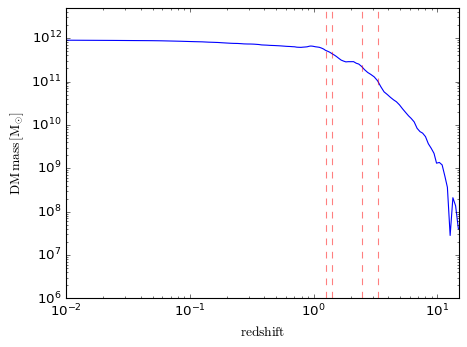

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax1.plot(t.data['reds'][first_progs_indices_main], t.data['smty'][first_progs_indices_main,1]*1e10)
for z in accr_z_infall:
    ax1.axvline(z, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('$\\rm redshift $')
ax1.set_ylabel('$\\rm{DM \, mass \, [M_{\odot}]}$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.01,15.)
ax1.set_ylim(1e6, 5e12)

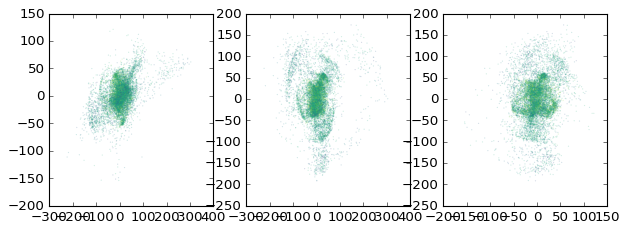

In [ ]:
"""Select 3rd most massive progenitor that merged with this Halo"""
index = 2
index_firstprog, = np.where( ( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[index] ) & (s.mdata['Exsitu']['AccretedFlag'] == 0) )
id_index_prog, = np.where( np.isin( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_firstprog] ) )
prog_star_positions = s.data['pos'][id_index_prog]
snapfb_thisprog = s.mdata['Exsitu']['BoundFirstTime'][index_firstprog]
c_index, = np.where( np.isin(s.mdata['Exsitu']['ParticleIDs'][index_firstprog], s.data['id']) )
isort2 = np.argsort(s.mdata['Exsitu']['ParticleIDs'][ index_firstprog ][c_index])
pcolors = ( snapfb_thisprog[c_index[isort2]] - snapfb_thisprog.min() ) / ( snapfb_thisprog.max() - snapfb_thisprog.min() )

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].scatter( prog_star_positions[:,1]*1e3, prog_star_positions[:,2]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
ax[1].scatter( prog_star_positions[:,1]*1e3, prog_star_positions[:,0]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
ax[2].scatter( prog_star_positions[:,2]*1e3, prog_star_positions[:,0]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
fig.show()

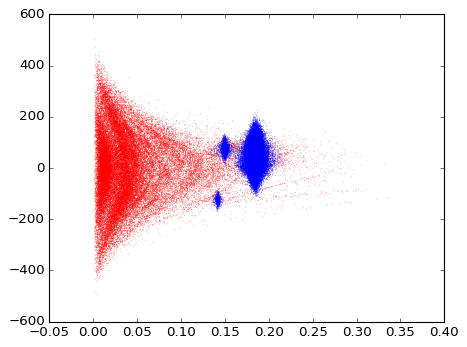

In [ ]:
index_accreted, = np.where((s.mdata['Exsitu']['AccretedFlag']==0))
id_index, = np.where( np.isin( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_accreted] ) )
prog_star_positions = s.data['pos'][id_index]
prog_star_velocities = s.data['vel'][id_index]
radii = np.sqrt( np.sum(prog_star_positions**2, axis=1) )
radial_velocities = np.sum(prog_star_positions * prog_star_velocities, axis=1) / radii

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.scatter( radii, radial_velocities, c='r', s=5, marker='.', linewidth=0, alpha=0.2 )

index_insat, = np.where((s.mdata['Exsitu']['AccretedFlag']==1))
id_index, = np.where( np.isin( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_insat] ) )
prog_star_positions = s.data['pos'][id_index]
prog_star_velocities = s.data['vel'][id_index]
radii = np.sqrt( np.sum(prog_star_positions**2, axis=1) )
radial_velocities = np.sum(prog_star_positions * prog_star_velocities, axis=1) / radii
ax.scatter( radii, radial_velocities, c='b', s=5, marker='.', linewidth=0, alpha=0.2 )

Doing progenitor 0 of 21
There are 100 unique root ids
Doing progenitor 1 of 21
There are 27 unique root ids
Doing progenitor 2 of 21
There are 39 unique root ids
Doing progenitor 3 of 21
There are 19 unique root ids
Doing progenitor 4 of 21
There are 9 unique root ids


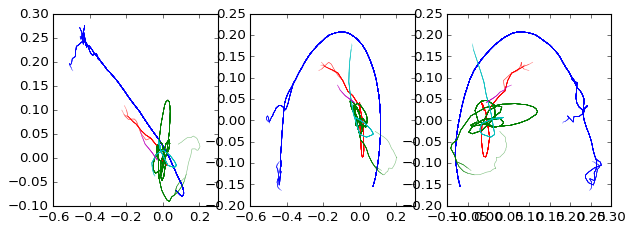

In [ ]:
fig2, ax2 = plt.subplots(1, 3, figsize=(9, 3))
colors = ['b', 'r', 'g', 'c', 'm', 'purple']
linecolorindex = 0
for i in range(min(5, len(first_prog))):
    index_firstprog0, = np.where( ( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[i] ) & (s.mdata['Exsitu']['AccretedFlag'] == 0) )
    rootids = s.mdata['Exsitu']['RootIndex'][ index_firstprog0 ]
    print('Doing progenitor %d of %d'%(i,len(first_prog)))
    print('There are %d unique root ids'%len(np.unique(rootids)))
    for j,rootid in enumerate(np.unique(rootids)):
        desc = rootid
        xpos = []
        ypos = []
        zpos = []
        desc_list = []
        while t.data['desc'][desc] != -1:
            if t.data['desc'][desc] == first_progs_indices_main[ snap_numbers_main==t.data['snum'][t.data['desc'][desc]] ]:# and desc != -1:
                #print('Breaking loop for desc=',desc)
                break
            desc = t.data['desc'][desc]
            desc_list.append(desc)
            main_index, = np.where( snap_numbers_main == t.data['snum'][desc] )
            try:
                    xpos.append(t.data['spos'][desc][2] - t.data['spos'][first_progs_indices_main[main_index]][0][2])
                    ypos.append(t.data['spos'][desc][1] - t.data['spos'][first_progs_indices_main[main_index]][0][1])
                    zpos.append(t.data['spos'][desc][0] - t.data['spos'][first_progs_indices_main[main_index]][0][0])
            except:
                    pass
        ax2[0].plot( ypos, xpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
        ax2[1].plot( ypos, zpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
        ax2[2].plot( xpos, zpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
    linecolorindex += 1

In [ ]:
gc_cand = (((1e10*s.data['imcl'][starparts][mask_cluster_final])>1e5).any(axis=1)) * (decomp_labels[mask_cluster_final] == sph_label)

In [ ]:
gcinsitu_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Insitu']['ParticleIDs']) )
index_accreted, = np.where((s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted]) )
index_accreted, = np.where((s.mdata['Exsitu']['AccretedFlag']==1))
gcexsitu1_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted]) )

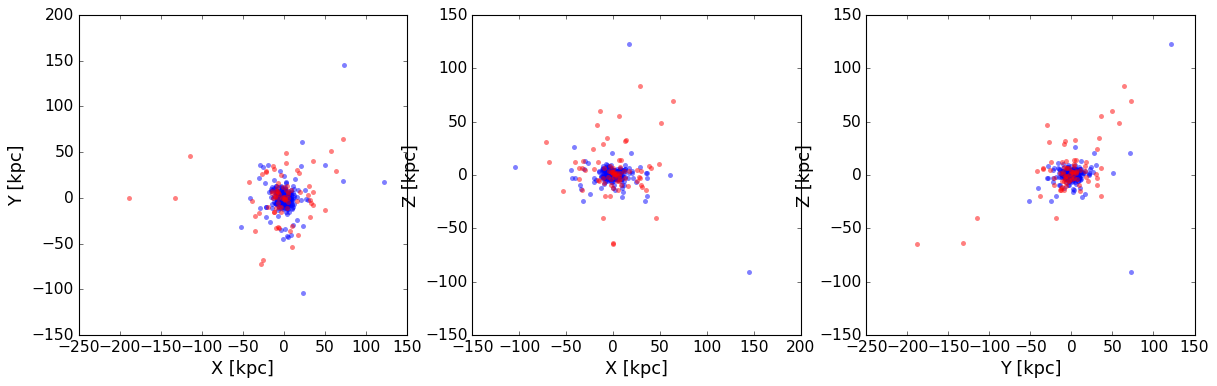

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,2],
                  alpha=0.5, linewidth=0, color='b')
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,2],
                  alpha=0.5, linewidth=0, color='r')
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu1_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu1_index,2],
                  alpha=0.5, linewidth=0, color='g')
# ax[0].set_xlim(-100,100)
# ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,0],
                  alpha=0.5, linewidth=0, color='b')
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,0],
                  alpha=0.5, linewidth=0, color='r')
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu1_index,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu1_index,0],
                  alpha=0.5, linewidth=0, color='g')
# ax[1].set_xlim(-100,100)
# ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,0],
                    alpha=0.5, linewidth=0, color='b')
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,0],
                    alpha=0.5, linewidth=0, color='r')
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu1_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu1_index,0],
                    alpha=0.5, linewidth=0, color='g')
# ax[2].set_xlim(-100,100)
# ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)

In [ ]:
insitu_radii = np.sqrt(np.sum(s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index]**2, axis=1))
exsitu_radii = np.sqrt(np.sum(s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index]**2, axis=1))
insat_radii = np.sqrt(np.sum(s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu1_index]**2, axis=1))
all_radii = np.sqrt(np.sum(s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand]**2, axis=1))

In [ ]:
len(insitu_radii), len(exsitu_radii), len(insat_radii), len(all_radii)

(778, 77, 0, 1047)

/tmp/ipykernel_674476/3033341240.py:23: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu/(N_insitu + N_exsitu + N_insat), linewidth=2, label='In-situ GCs', color='k')
/tmp/ipykernel_674476/3033341240.py:25: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu/(N_insitu + N_exsitu + N_insat), linewidth=2, label='Ex-situ GCs', color='r')
/tmp/ipykernel_674476/3033341240.py:27: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_insat/(N_insitu + N_exsitu + N_insat), linewidth=2, label='In satellites GCs', color='g')


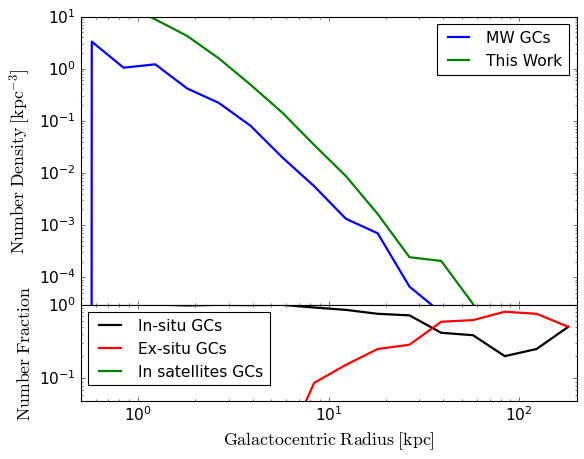

In [ ]:
mw_radii = mw_catalogue[:,2]
gc_radii = np.repeat(1e3*s.r()[s.data['type']==4][starparts][mask_cluster_initial],s.data['incl'][starparts][mask_cluster_initial])[(mclus_i>1e5) * (labels_i==sph_label) * (mclus_m>0)]
bins = np.logspace(-1, 2.5, 22)
mw_hist, _ = np.histogram(mw_radii, bins=bins)
mw_density = mw_hist / (4.*np.pi*( (bins[1:]**3 - bins[:-1]**3)/3. ))
gc_hist, _ = np.histogram(gc_radii, bins=bins)
gc_density = gc_hist / (4.*np.pi*( (bins[1:]**3 - bins[:-1]**3)/3. ))

N_insitu, _ = np.histogram(1e3*insitu_radii, bins=bins)
N_exsitu, _ = np.histogram(1e3*exsitu_radii, bins=bins)
N_insat, _ = np.histogram(1e3*insat_radii, bins=bins)
N_all, _ = np.histogram(1e3*all_radii, bins=bins)

fig, ax = plt.subplots(2, 1, sharex=True, height_ratios=[3,1])
ax[0].loglog((bins[1:] + bins[:-1]) / 2., mw_density, linewidth=2, label='MW GCs')
ax[0].loglog((bins[1:] + bins[:-1]) / 2., gc_density, linewidth=2, label='This Work')
ax[0].set_ylim(3e-5, 1e1)
ax[0].set_ylabel(r'$\mathrm{Number \; Density \; [kpc^{-3}]}$', fontsize=16)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', which='both', labelsize=14)

# ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu/N_all, linewidth=2, label='In-situ GCs', color='k')
ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu/(N_insitu + N_exsitu + N_insat), linewidth=2, label='In-situ GCs', color='k')
# ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu/N_all, linewidth=2, label='Ex-situ GCs', color='r')
ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu/(N_insitu + N_exsitu + N_insat), linewidth=2, label='Ex-situ GCs', color='r')
# ax[1].loglog((bins[1:]+bins[:-1])/2., N_insat/N_all, linewidth=2, label='In satellites GCs', color='g')
ax[1].loglog((bins[1:]+bins[:-1])/2., N_insat/(N_insitu + N_exsitu + N_insat), linewidth=2, label='In satellites GCs', color='g')
ax[1].set_ylabel(r'$\rm{Number \; Fraction}$', fontsize=16)
ax[1].legend(loc='upper left', fontsize=14)
ax[1].tick_params(axis='both', which='both', labelsize=14)
ax[1].set_xlabel(r'$\mathrm{Galactocentric \; Radius \; [kpc]}$', fontsize=16)
ax[1].set_xlim(5e-1, 2e2)
ax[1].set_ylim(5e-2, 1)

plt.subplots_adjust(hspace=0.0)
# plt.savefig('./plots/insitu_exsitu_gcs_paper.pdf', bbox_inches='tight')

In [ ]:
index_accreted_1p, = np.where(( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[0] ) & (s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_1p_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted_1p] ) )
index_accreted_2p, = np.where(( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[1] ) & (s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_2p_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted_2p] ) )
index_accreted_3p, = np.where(( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[2] ) & (s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_3p_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted_3p] ) )

(-3.5, 0.5)

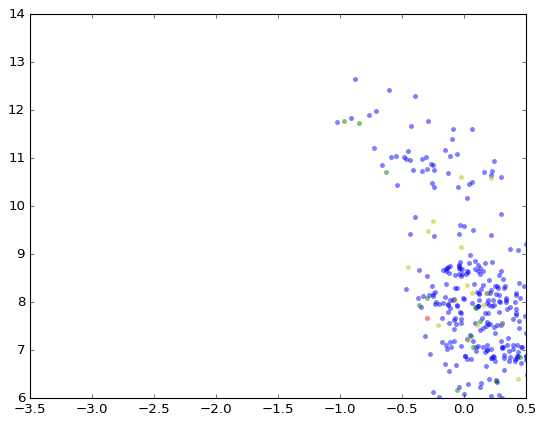

In [ ]:
# plt.scatter(feh_scs, clus_age, c='b', linewidths=0, alpha=0.5)
plt.scatter(feh_scs[gcinsitu_index], clus_age[gcinsitu_index], c='b', linewidths=0, alpha=0.5)
plt.scatter(feh_scs[gcexsitu_1p_index], clus_age[gcexsitu_1p_index], c='r', linewidths=0, alpha=0.5)
plt.scatter(feh_scs[gcexsitu_2p_index], clus_age[gcexsitu_2p_index], c='y', linewidths=0, alpha=0.5)
plt.scatter(feh_scs[gcexsitu_3p_index], clus_age[gcexsitu_3p_index], c='g', linewidths=0, alpha=0.5)
plt.ylim(6,14)
plt.xlim(-3.5, 0.5)

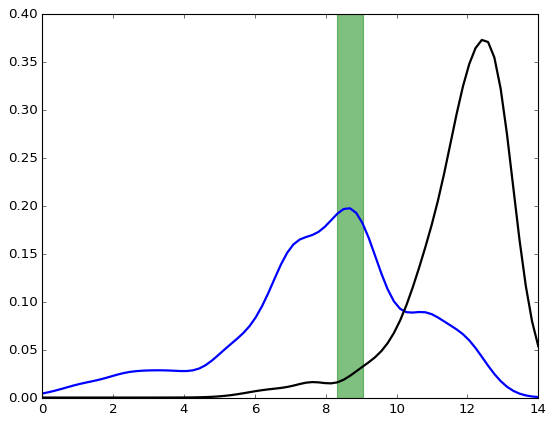

In [ ]:
age_bins = np.linspace(0,14,80)
age_gc = np.array([sp.stats.norm.pdf(age_bins, loc=age, scale=0.5) 
                   for age in clus_age_i[(mclus_m > 0.) * (labels_i == sph_label) * (mclus_i > 1e5)]]).sum(axis=0)

mw_age_cat = np.genfromtxt('catalogues_compare/kruijssen_age_catalogue.txt', delimiter=',', skip_header=2, usecols=(12,13))
mw_age_dist = np.array([sp.stats.norm.pdf(age_bins, loc=mw_age_cat[i,0], scale=mw_age_cat[i,1]) for i in range(len(mw_age_cat))]).sum(axis=0)

plt.plot(age_bins, age_gc/np.trapezoid(age_gc, age_bins), linewidth=2)
plt.plot(age_bins, mw_age_dist/np.trapezoid(mw_age_dist, age_bins), c='k', linewidth=2)

# for val in accr_time_infall:
#     plt.axvline(val, color='r', linestyle='--', alpha=0.5)

peak_age_dist = age_bins[np.argmax(age_gc)]
plt.fill_between(age_bins, 0, 0.4, where=(age_bins > peak_age_dist - 0.5) & (age_bins < peak_age_dist + 0.5), color='g', alpha=0.5)

In [ ]:
# find star particles with GCs born within 1 Gyr of peak
peak_age_mask = (stars_age[mask_cluster_final * (decomp_labels == sph_label)] > peak_age_dist - 0.5) * (stars_age[mask_cluster_final * (decomp_labels == sph_label)] < peak_age_dist + 0.5)

In [ ]:
ids_peak = s.data['id'][s.data['type']==4][starparts][mask_cluster_final * (decomp_labels == sph_label)][peak_age_mask]
form_time_peak = s.data['age'][np.isin(s.data['id'][s.data['type']==4], ids_peak)]
print('Found %d star particles with GCs born within 1 Gyr of the peak'%len(form_time_peak))

Found 549 star particles with GCs born within 1 Gyr of the peak


In [ ]:
exp_list = np.genfromtxt('AREPO_CONFIG/param_files/ExpansionList_128', delimiter=' ')
exp_list_mask = (exp_list[:,0] > form_time_peak.min()) * (exp_list[:,0] < form_time_peak.max())

exp_list_mask[:-1] = exp_list_mask[1:] | exp_list_mask[:-1]
exp_list_mask[1:] = exp_list_mask[1:] | exp_list_mask[:-1]

exp_list = exp_list[exp_list_mask]

In [ ]:
s.cosmology_get_lookback_time_from_a(exp_list[:,0], is_flat=True)

array([9.30680302, 9.15295466, 8.99889582, 8.84462251, 8.69013103,
       8.53541784, 8.3804797 , 8.22531354, 8.06991654])

In [15]:
directory = []
for sim in simulation_list:
    directory.append(parent_dir)

In [ ]:
def get_stellar_projection_with_clusters(s, ids, res, boxsize, numthreads, projection='faceon'):
    istars, = np.where(np.isin(s.data['id'][(s.type == 4)], ids))

    pos_orig = s.pos[istars].astype('f8')
    mass = s.data['mass'][istars].astype('f8')

    particle_oct_tree = makeTree( pos_orig )
    hsml = particle_oct_tree.calcHsmlMulti( pos_orig, pos_orig, mass, 48, numthreads=numthreads )
    hsml = np.minimum( hsml, 4. * boxsize / res )
    hsml = np.maximum( hsml, 1.001 * boxsize / res * 0.5 )

    rho = np.ones( np.size(mass) )

    datarange = np.array( [ [4003.36,800672.], [199.370,132913.], [133.698,200548.] ] ) # ranges for each colour channel to make nice images ;)
    fac = (512./res)**2 * (0.5 * boxsize / 0.025)**2 # Normalised pixel area
    datarange *= fac

    pos = np.zeros( (size(istars),3) )
    if projection == 'faceon':
        pos[:,0] = pos_orig[:,1]
        pos[:,1] = pos_orig[:,2]
        pos[:,2] = pos_orig[:,0]
        xres = res
        yres = res
        boxx = boxsize
        boxy = boxsize
    elif projection == 'edgeon':
        pos[:,0] = pos_orig[:,0]
        pos[:,1] = pos_orig[:,2]
        pos[:,2] = pos_orig[:,1]
        xres = res//2
        yres = res
        boxx = boxsize/2.
        boxy = boxsize

    proj = np.zeros( (xres,yres,3) )

    """Import requried C routines"""
    import calcGrid 

    boxz = max( boxx, boxy )

    for k in range(3):
        iband = [3,1,0][k]
        band = 10 ** ( -2.0 * s.data['gsph'][istars,iband] / 5.0 )

        grid = calcGrid.calcGrid( pos, hsml, band.astype('f8'), rho, rho, xres, yres, 256, boxx, boxy, boxz, 
                                0., 0., 0., 1, 1, numthreads=numthreads )

        drange = datarange[k]
        grid = np.minimum( np.maximum( grid, drange[0] ), drange[1] )
        loggrid = np.log10( grid )
        logdrange = np.log10( drange )

        proj[:,:,k] = (loggrid - logdrange[0]) / (logdrange[1] - logdrange[0])

    gray = 5.* color.rgb2gray(proj)
    coordinates = peak_local_max(gray, min_distance=1, num_peaks=len(ids))

    return coordinates

In [19]:
proj = auriga_projection()
proj.add_directory([directory[sim_id]], [simulation_list[sim_id]])

path,halos= ['./level4/'] ['Au06_cfea_fiducial']
halos= ['Au06_cfea_fiducial']
Found 128 snapshots for halo ./level4//Au06_cfea_fiducial.
directories= [<projections_load.auriga_directory object at 0x7f75f8e6c730>]


Processing group: 1
select_haloes
select_haloes
Selected snapshot number: 70
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.010784763
Found 256616 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 523019 of 1948839 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  85098097.66079691
Selected 462324 of 1948839 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  150661562.49403498
Adding time to plot.
Found 8 clusters in face-on projection out of 9


/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


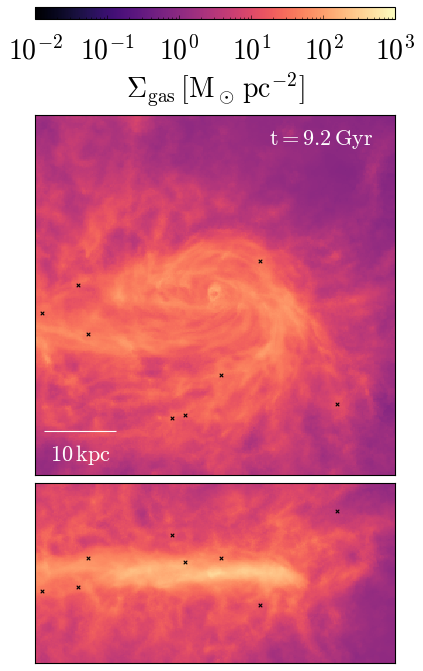

Processing group: 2
select_haloes
select_haloes
Selected snapshot number: 71
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.011325753
Found 271420 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 682464 of 2006317 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  110536166.34621301


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Selected 618265 of 2006317 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025
Total is  200374920.39955822
Adding time to plot.
Found 55 clusters in face-on projection out of 82


/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


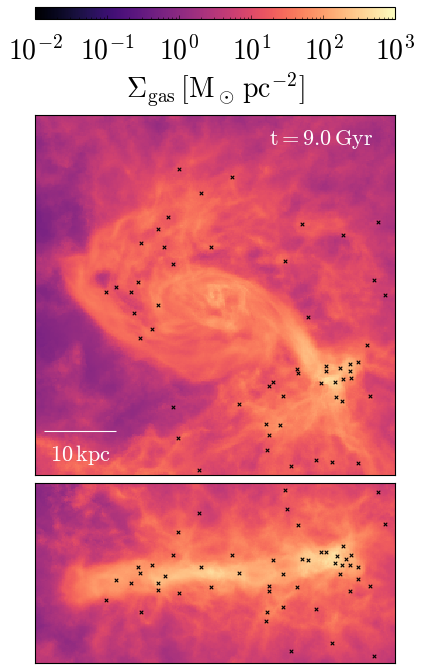

Processing group: 3
select_haloes
select_haloes
Selected snapshot number: 72
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.01200604
Found 312090 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 707260 of 2052863 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  113654213.75910574
Selected 612832 of 2052863 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  196843356.14075506
Adding time to plot.
Found 60 clusters in face-on projection out of 97


/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


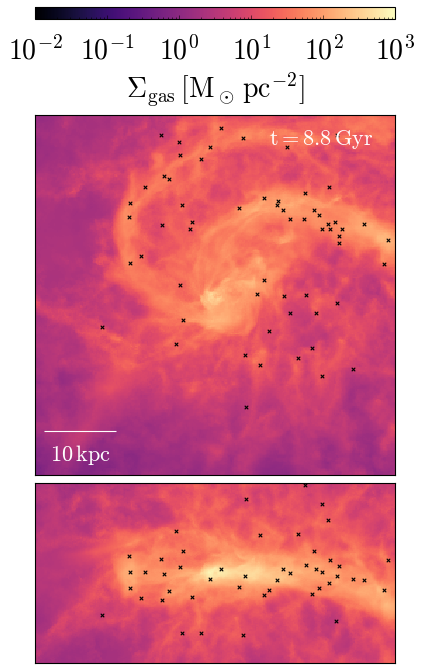

Processing group: 4
select_haloes
select_haloes
Selected snapshot number: 73
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.012351025
Found 350160 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 602957 of 2070250 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  97329570.55793732
Selected 526226 of 2070250 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  170060547.14373872
Adding time to plot.
Found 38 clusters in face-on projection out of 74


/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


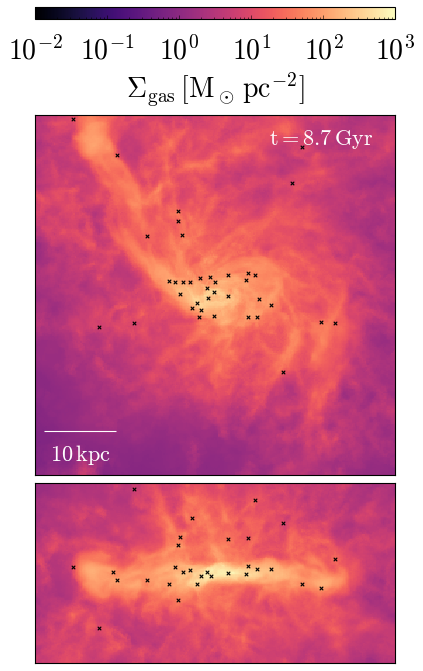

Processing group: 5
select_haloes
select_haloes
Selected snapshot number: 74
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.012709098
Found 403123 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 620135 of 2087501 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  101002333.08058864
Selected 510595 of 2087501 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025
Creating tree for 523019 particles with 1569057 nodes.
Domainlen: 0.0524999
Tree creation took 0.553434s
Starting tree walk with 8 thread(s), nx=256, ny=256, nz=256, cellx=0.000195313, celly=0.000195313, cellz=0.000195313, cx=0, cy=0, cz=0
Tree walk took 17.7061s
Calculation took 18.3075s
Creating tree for 462324 particles with 1386972 nodes.
Domainlen: 0.0524998
Tree creation took 0.109622s
Starting tree walk with 8 thread(s), nx=256, ny=256, nz=256, cellx=0.000195313, celly=9.76563e-05, cellz=0.000195313, cx=0, cy=0, cz=0
Tree walk took 17.5069s
Ca

/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


nlen: 0.0525
Tree creation took 0.62522s
Starting tree walk with 8 thread(s), nx=256, ny=256, nz=256, cellx=0.000195313, celly=0.000195313, cellz=0.000195313, cx=0, cy=0, cz=0
Tree walk took 19.4537s
Calculation took 20.1424s
Creating tree for 618265 particles with 1854795 nodes.
Domainlen: 0.0524999
Tree creation took 0.150527s
Starting tree walk with 8 thread(s), nx=256, ny=256, nz=256, cellx=0.000195313, celly=9.76563e-05, cellz=0.000195313, cx=0, cy=0, cz=0
Tree walk took 20.4071s
Calculation took 20.5598s
Creating tree for 82 particles with 246 nodes.
Domainlen: 0.0607671
Tree creation took 4.7e-05s
Doing 82 positions with 8 thread(s).
No hsmlGuess found.
Hsml calculation took 0.00045s
Creating tree for 82 particles with 246 nodes.
Domainlen: 0.0607671
Tree creation took 4.3e-05s
Doing 82 positions with 8 thread(s).
No hsmlGuess found.
Hsml calculation took 0.000429s
Creating tree for 707260 particles with 2121780 nodes.
Domainlen: 0.0525
Tree creation took 0.597304s
Starting tree

/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


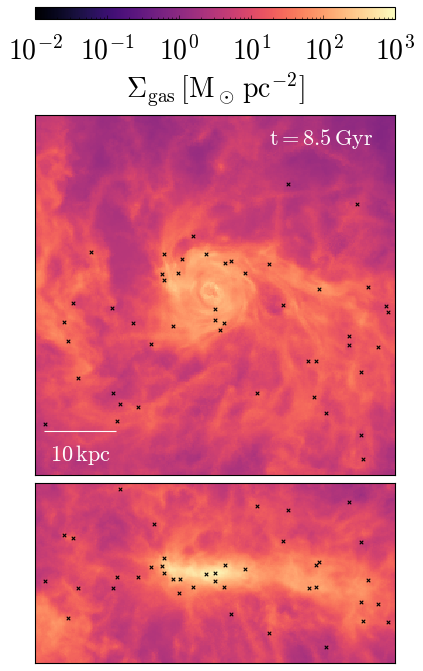

Processing group: 6
select_haloes
select_haloes
Selected snapshot number: 75
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.012961253
Found 403707 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 696060 of 2104185 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  113341468.7003578
Selected 597009 of 2104185 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  194595327.21745336
Adding time to plot.
Found 42 clusters in face-on projection out of 90


/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


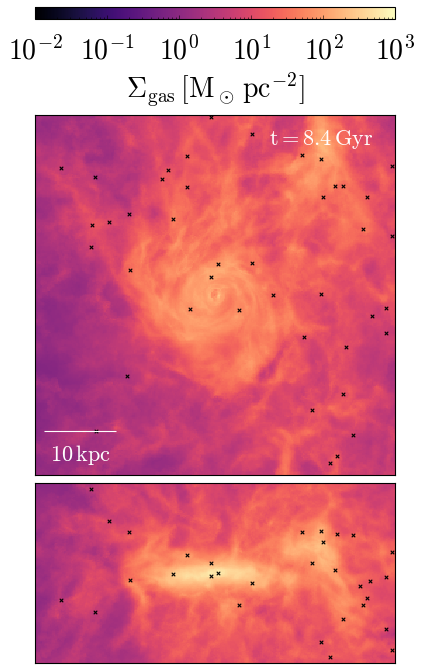

Processing group: 7
select_haloes
select_haloes
Selected snapshot number: 76
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.013185143
Found 430177 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 612677 of 2114584 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  99813065.5390703
Selected 517572 of 2114584 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  168793624.1145941
Adding time to plot.
Found 39 clusters in face-on projection out of 79


/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


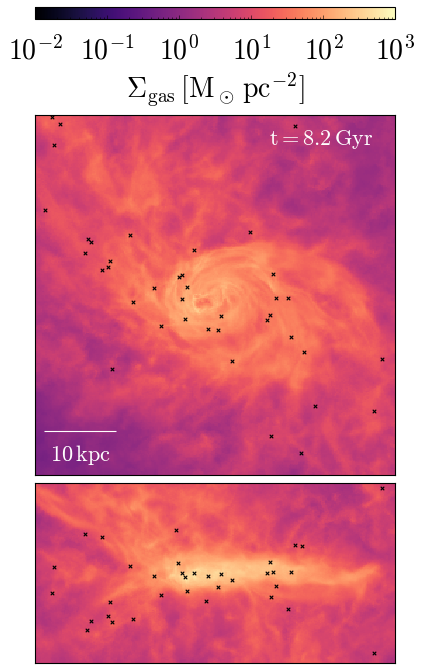

Processing group: 8
select_haloes
select_haloes
Selected snapshot number: 77
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.013433613
Found 453267 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 557022 of 2133734 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  90833606.30166519
Selected 479879 of 2133734 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  156566150.9504775
Adding time to plot.
Found 7 clusters in face-on projection out of 18


/tmp/ipykernel_784316/3648270649.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
/tmp/ipykernel_784316/3648270649.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')


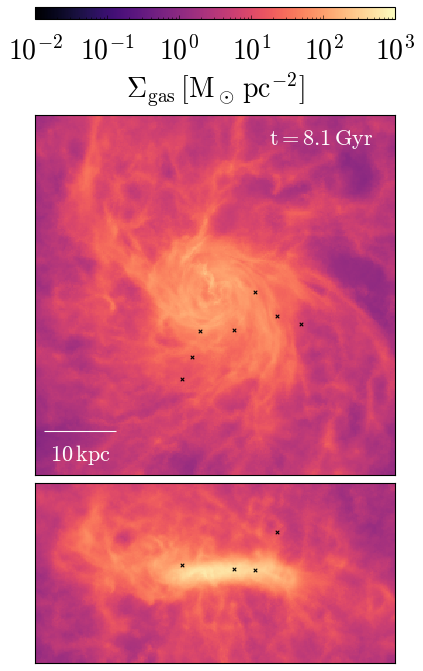

In [ ]:
ncols=1
nrows=1
figsize=6.
nhalos = 0
isnap = 0
boxsize=0.05
numthreads=8
res=256
nlevels = size(proj)

for i in range(len(exp_list) - 1):
    print('Processing group:', i + 1)
    mask_snap = (form_time_peak > exp_list[i,0]) * (form_time_peak < exp_list[i+1,0])
    
    proj.select_halos((1./exp_list[i+1,0]) - 1.)
    nhalos += proj.selected_current_nsnaps
    f = plt.figure( FigureClass=sfig, figsize=( figsize*ncols, figsize*1.5*nrows ) )
    proj.select_halos((1./exp_list[i+1,0]) - 1., loadonlytype=[0,4,5], loadonlyhalo=0, loadonly=['id','pos','vol','rho','mass','vel', 'vol','gsph'] )
    tcolor='w'
    print('Selected snapshot number:', proj.selected_snapnums[0])
    for isi, sn in enumerate(proj):
        sn.calc_sf_indizes( sn.subfind, absolutesubnum=True)
        print('Selecting halo without merger tree of most bound DM particle information.')
        sn.select_halo( sn.subfind, rotate_disk=True, do_rotation=True, use_principal_axis=True)
        ax, ax2, x, y, y2, area = create_axis( f, isnap, ncol=ncols, res=res, boxsize=boxsize, cb=True )
        ax, ax2 = projfuncs["gas_density"]( sn, f, ax, ax2, area, x, y, y2, isnap, boxsize=boxsize, numthreads=numthreads, res=res, projflag=True, cosmo=proj.cosmo )
        pix_per_kpc = boxsize / (x.max() - x.min())
        barlen = 0.01 * pix_per_kpc
        asb = AnchoredSizeBar(ax.transData,
                                barlen,
                                r"$\rm{10\, kpc}$",
                                fontproperties=fm.FontProperties(size=20, family='monospace'),
                                loc=3,
                                pad=0.2, borderpad=0.2, sep=10, color=tcolor,
                                frameon=False)
        ax.add_artist(asb)
        time = sn.cosmology_get_lookback_time_from_a(sn.time, is_flat=True)
        print('Adding time to plot.')
        ax.text( 0.65, 0.92, "$\\rm{t=%1.1f\,Gyr}$" % (time), color=tcolor, fontsize=20, transform=ax.transAxes )
        set_axis( isnap * nlevels + isnap, ax, ax2 )

        coords_face = get_stellar_projection_with_clusters(sn, ids_peak[mask_snap], res, boxsize, numthreads, projection='faceon')
        coords_edge = get_stellar_projection_with_clusters(sn, ids_peak[mask_snap], res, boxsize, numthreads, projection='edgeon')
        print('Found %d clusters in face-on projection out of %d'%(coords_face.shape[0], len(ids_peak[mask_snap])))
        
        ax.scatter( boxsize/res * coords_face[:,1] - 0.5*boxsize, -1.*boxsize/res * coords_face[:,0] + 0.5*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
        ax2.scatter( boxsize/res * coords_edge[:,1] - 0.5*boxsize, -0.5*boxsize/(res//2) * coords_edge[:,0] + 0.25*boxsize, marker='x', s=10, facecolors='k', edgecolors='k')
        plt.show()

In [ ]:
age_thresh = 13.6 # in Gyr

# TT_star = tensor[s.data['type']==4][starparts] / s.parameters['UnitTime_in_s']**2
# finite_mask_s = np.isfinite(TT_star).all(axis=1)
# TT_star = TT_star[finite_mask_s]

# TT_birth_lambda = np.linalg.eigvalsh(TT_star.reshape(len(TT_star),3,3))
# TT_birth_lambda = np.sort(TT_birth_lambda, axis=1)

TT_birth_lambda = s.data['beig'][starparts] / s.parameters['UnitTime_in_s']**2

omega2_star = 0.3333 * np.abs((TT_birth_lambda).sum(axis=1))
G_cgs = 6.67430e-8  # Gravitational constant in CGS units
rho_ism = 3 * omega2_star / (np.pi * G_cgs)  # in g/cm^3
rho_ism *= parsec**3 / solar_mass_g  # convert to Msun/pc^3

rho_ism_clus = np.repeat(rho_ism, s.data['incl'][starparts])[clus_age_i < age_thresh]

In [ ]:
#lets estimate for new clusters
t5cce = 176 # Myr
dens_msolpc3 = rho_ism_clus
rho_h_i = 3. * mclus_i / (8. * np.pi * rh_i**3. )
phi_ad = (1 + 9.*(rho_h_i[clus_age_i<age_thresh] / dens_msolpc3/1e4))**(-1.5)
surfdens_i = np.repeat(s.data['bsig'][starparts] * surface_dens_units * parsec**2/solar_mass_g / 100., s.data['incl'][starparts])[clus_age_i < age_thresh]
fmol = 1/(1 + 0.025*surfdens_i**(-2.))
fsigma = 3.92 * (0.5*(10 - 8*fmol))**0.5

In [ ]:
tcce = t5cce * (4./fsigma) * (dens_msolpc3)**(-1.5) * (mclus_i[clus_age_i < age_thresh] / 1e5) / phi_ad
print('Fraction of early disruption', ((mclus_i[clus_age_i < age_thresh] - (mclus_i[clus_age_i < age_thresh]/tcce * 100))<0).sum()/len(mclus_i[clus_age_i < age_thresh]))
print('Number of clusters evaluated (age < %.2f Myr): %d'%(age_thresh*1e3, len(mclus_i[clus_age_i < age_thresh])))

Fraction of early disruption 0.15744422726966367
Number of clusters evaluated (age < 13600.00 Myr): 44511


Text(0, 0.5, 'Number')

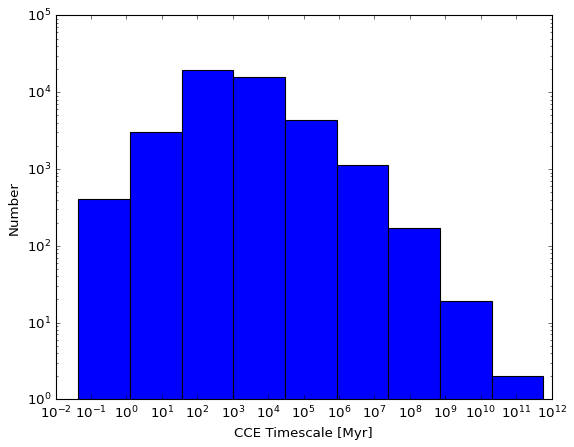

In [ ]:
plt.hist(tcce[~np.isnan(tcce)], bins=np.logspace(np.log10(np.nanmin(tcce)),np.log10(np.nanmax(tcce)),10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('CCE Timescale [Myr]')
plt.ylabel('Number')